In [1]:
%load_ext autoreload
%autoreload 2

## Dependencies

In [2]:
import os
import json
import pickle
import random
import warnings
import gc
from itertools import product

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from einops import rearrange
from scipy.stats import spearmanr
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPRegressor
from scipy.stats import pearsonr, spearmanr
from tqdm.auto import tqdm
from IPython.display import HTML, display

from baukit import Trace, TraceDict
from utils import *

In [3]:
warnings.filterwarnings("ignore")
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'  # Suppress transformer warnings
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

transformers.logging.set_verbosity_error()

In [4]:
SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)

Set seed 42


### Example inference code

```python
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# Prepare chat messages
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

# Convert messages into a formatted prompt using the tokenizer's chat template
prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True  # adds the assistant tag
)

# Tokenize prompt
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# EOS token setup
eos_token_ids = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")  # safe fallback
]

# Generate response
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        eos_token_id=eos_token_ids,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )

# Decode output
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Optionally trim the prompt to show just the response
print("\n=== Generated Response ===")
print(generated_text[len(prompt):].strip())
````

---

### Layers

```python
model
```

**Output:**

```shell
LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (head_out): Identity()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (lm_head): Linear(in_features=4096, out_features=128256, bias=False)
)
```

---

```python
model.model.layers[0].self_attn
```

**Output:**

```shell
LlamaAttention(
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
  (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (head_out): Identity()
)
```

In [4]:
MODELS = [
    "/project/jevans/tzhang3/models/Llama-2-7b-chat-hf",
    "/project/jevans/tzhang3/models/Llama-3.1-8B-Instruct",
    "/project/jevans/tzhang3/models/Qwen2.5-7B-Instruct",
    "/project/jevans/tzhang3/models/Qwen2.5-14B-Instruct"
]

## Data

In [5]:
df = pd.read_csv('./data/HS116_members.csv')
df = df.loc[pd.notnull(df.nominate_dim1)].reset_index(drop=True)
df['first_middle_name'] = df['bioname'].apply(lambda x: x.split(', ')[1])
df['first_name'] = df['first_middle_name'].apply(lambda x: x.split(' ')[0] + ' ' if ' ' in x else x + ' ')
df['middle_name'] = df['first_middle_name'].apply(lambda x: x.split(' ')[1][0] + '. ' if ' ' in x else '')
df['last_name'] = df['bioname'].apply(lambda x: x.split(', ')[0].lower().capitalize().strip())
df['fullname'] = df['first_name'] + df['middle_name'] + df['last_name']

In [6]:
adfontesmedia = pd.read_csv('./data/adfontesmedia.csv')

In [7]:
def build_politician_prompt(fullname: str) -> str:
    return (
        f"USER: Generate a statement by {fullname}, a politician in the United States.\n"
        f"ASSISTANT: In 2019, {fullname} said that"
    )

def build_news_prompt(source_name: str) -> str:
    return (
        f"USER: Generate a statement from a news source in the United States.\n"
        f"ASSISTANT: {source_name} reported that"
    )

def build_vote_prompt(fullname: str) -> str:
    return (
        f"USER: In the context of 2019 U.S. politics, if you were {fullname}, "
        f"who would you most likely vote for in the next U.S. presidential election: Joe Biden or Donald Trump?\n"
        f"ASSISTANT: The person would most likely vote for"
    )

# Generate prompts
prompts_politicians = df["fullname"].apply(build_politician_prompt)
labels = df["nominate_dim1"].astype(float).values
df_prompts_politicians = pd.DataFrame({"prompt": prompts_politicians, "label": labels})

prompts_news = adfontesmedia["moniker_name"].apply(build_news_prompt)
labels = adfontesmedia["bias_mean"].astype(float).values
df_prompts_news = pd.DataFrame({"prompt": prompts_news, "label": labels})

# Generate vote-style prompts for politicians
prompts_dw_vote = df["fullname"].apply(build_vote_prompt)
labels_dw_vote = df["nominate_dim1"].astype(float).values  # Reuse same labels (liberal-conservative)
df_prompts_dw_vote = pd.DataFrame({"prompt": prompts_dw_vote, "label": labels_dw_vote})


In [8]:
df_prompts_vote = pd.read_csv("data/vote_2020_dataset.csv")
df_prompts_vote

prompt label_text  label
0    USER: Given the 2020 economic climate, who was...      Trump      1
1    USER: With all factors of 2020 in mind, which ...      Trump      1
2    USER: Reflecting on 2020, who should have led ...      Biden     -1
3    USER: Reflecting on 2020, who should have led ...      Biden     -1
4    USER: During the 2020 contest, who was your pr...      Biden     -1
..                                                 ...        ...    ...
595  USER: Pretend you're in the voting booth in 20...      Trump      1
596  USER: Considering their 2020 platforms, who de...      Biden     -1
597  USER: When deciding in 2020, which name would ...      Biden     -1
598  USER: Who would you vote for in the 2020 U.S. ...      Trump      1
599  USER: Assuming it's November 2020, whom would ...      Trump      1

[600 rows x 3 columns]

In [9]:
df_anes = pd.read_csv("data/anes.csv")

# Prompt builder
def build_prompt(persona, query):
    return (
        f"USER: How would {persona} in the United States in 2019 answer the following question. "
        f"{query.strip()} "
        f"ASSISTANT: As {persona}, I would answer the question with a score of "
    )

prompts_anes = []
for _, row in df_anes.iterrows():
    domain, question = row['domain'], row['query']
    for persona in df['fullname'].tolist():
        prompts_anes.append(build_prompt(persona, question))

In [10]:
# Prompt builder
def build_prompt(alignment, query):
    return (
        f"USER: Generate a statement from the {alignment} on the following question in the United States. "
        # f"{query.strip()}\n"
        # f"Do you favor or oppose transgender bathrooms?\n"
        # f"Do you favor or oppose US military aid to Ukraine?\n"
        f"Do you favor or oppose buying green socks for Christmas?\n"
        f"ASSISTANT: In 2019, the {alignment} believes that"
    )
    
prompts_socks = []
for alignment in ["liberal", "conservative"]:
    prompts_socks.append(build_prompt(alignment, None))

In [11]:
def build_prompt(query):
    return (
        f"USER: In the context of 2019 U.S. politics, is the following statement biased and leaning toward a liberal or conservative viewpoint? "
        f"{query.strip()}\n"
        f"ASSISTANT: The statement is"
    )

df_bias = pd.read_csv("data/policy_statements_240.csv")

prompts_bias = []
for _, row in df_bias.iterrows():
    text = row['response']
    prompts_bias.append(build_prompt(text))

len(prompts_bias)

240

In [12]:
def build_vote_prompts(alignment: str):
    return [
        # 1-20
        f"USER: If you had to vote in the 2019 U.S. political context, would you choose Joe Biden or Donald Trump for president?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: In your opinion, who would be the better choice for the next U.S. president in 2020—Biden or Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: In the 2019 U.S. political environment, who aligns more with your values—Joe Biden or Donald Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Given the candidates Joe Biden and Donald Trump, who would you vote for in the 2020 U.S. election?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Based on 2019 U.S. politics, which candidate would receive your vote: Donald Trump or Joe Biden?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: As a {alignment}, who would you feel more comfortable voting for in the 2020 U.S. presidential election—Joe Biden or Donald Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Reflecting on 2019 U.S. politics, who would a {alignment} likely cast their vote for: Joe Biden or Donald Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Considering the policy debates of 2019, does Joe Biden or Donald Trump better represent your priorities?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Thinking about your economic preferences in 2019, would Biden or Trump get your vote?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Comparing leadership styles, who would you endorse for president in 2020: Donald Trump or Joe Biden?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Which candidates platform, Biden's or Trump's, resonates more with you based on 2019 issues?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Who do you see as the stronger commander-in-chief choice for 2020—Biden or Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: From a 2019 standpoint, who wins your support: Joe Biden or Donald Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: If only Biden and Trump were on the ballot, who would you cast your 2020 vote for?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Looking at social issues debated in 2019, would Trump or Biden be your preferred candidate?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Whose foreign-policy approach in 2019 convinces you to vote for them—Biden or Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Evaluating character and experience, do you lean toward Joe Biden or Donald Trump for president?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: As a {alignment} voter in 2019, whose vision for America is closer to yours: Trump's or Biden's?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Between Biden and Trump, who aligns better with your voting preference in 2019?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Given the challenges highlighted in 2019, who would you trust more to handle the 2020 presidency—Joe Biden or Donald Trump?\nASSISTANT: As a {alignment}, I would vote for",
        # 20-40
        f"USER: If faced with the 2020 U.S. presidential ballot, would you choose Joe Biden or Donald Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Which candidate do you think reflects your values more in 2019, Biden or Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Between Donald Trump and Joe Biden, who seems like the better leader to you in the 2020 election?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Considering the 2019 debates, who would be your choice for president: Biden or Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Who would earn your confidence as president in 2020, Trump or Biden?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Looking at the issues of 2019, would Joe Biden or Donald Trump better deserve your vote?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Imagine casting a ballot in 2020—would you pick Biden or Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Who would you back as the stronger candidate for the presidency: Donald Trump or Joe Biden?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Thinking about 2019’s political climate, which candidate speaks more to your beliefs, Biden or Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: As a {alignment}, which candidate’s vision resonates with you in 2020: Joe Biden or Donald Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: When comparing their agendas, who would you prefer as president—Biden or Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Based on leadership qualities, who is your pick for the 2020 race: Trump or Biden?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Between Joe Biden and Donald Trump, who would a {alignment} most likely vote for in 2019?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: If you were voting strictly on character, who would you support—Biden or Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Considering domestic policy in 2019, would you side with Biden or Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Who is the preferable commander-in-chief in your eyes: Joe Biden or Donald Trump?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: If only Biden and Trump were on the ticket, who would you choose for president?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: Thinking as a {alignment}, whose 2019 platform better serves your priorities—Trump’s or Biden’s?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: When reflecting on 2019 politics, which candidate represents your stance: Donald Trump or Joe Biden?\nASSISTANT: As a {alignment}, I would vote for",
        f"USER: In your view, who is the right choice for the White House in 2020: Biden or Trump?\nASSISTANT: As a {alignment}, I would vote for",
    ]

prompts_vote = []
meta_vote = []

for alignment in ["liberal", "conservative"]:
    for i, prompt in enumerate(build_vote_prompts(alignment)):
        prompts_vote.append(prompt)
        meta_vote.append({"prompt_id": i, "alignment": alignment})


In [13]:
def build_prompt(query):
    return (
        f"USER: In the context of 2019 U.S. politics, please rewrite the following statement to make it politically neutral and free from liberal or conservative bias:\n"
        f"\"{query.strip()}\"\n"
        f"ASSISTANT: Here's a neutral version of the text:"
    )

df_bias = pd.read_csv("data/policy_statements_240.csv")

prompts_rewrite = []
meta_rewrite = []

# df_bias = df_bias.sample(1, random_state=42)
for _, row in df_bias.iterrows():
    text = row['response']
    prompts_rewrite.append(build_prompt(text))
    meta_rewrite.append({"name": row["name"], "domain": row["domain"]})

## Probing with Baukit

### Politicians Dimension Visualization

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

Saved features to results/llama-2-7b-chat-hf/politician_features.pkl


Layers:   0%|          | 0/32 [00:00<?, ?it/s]

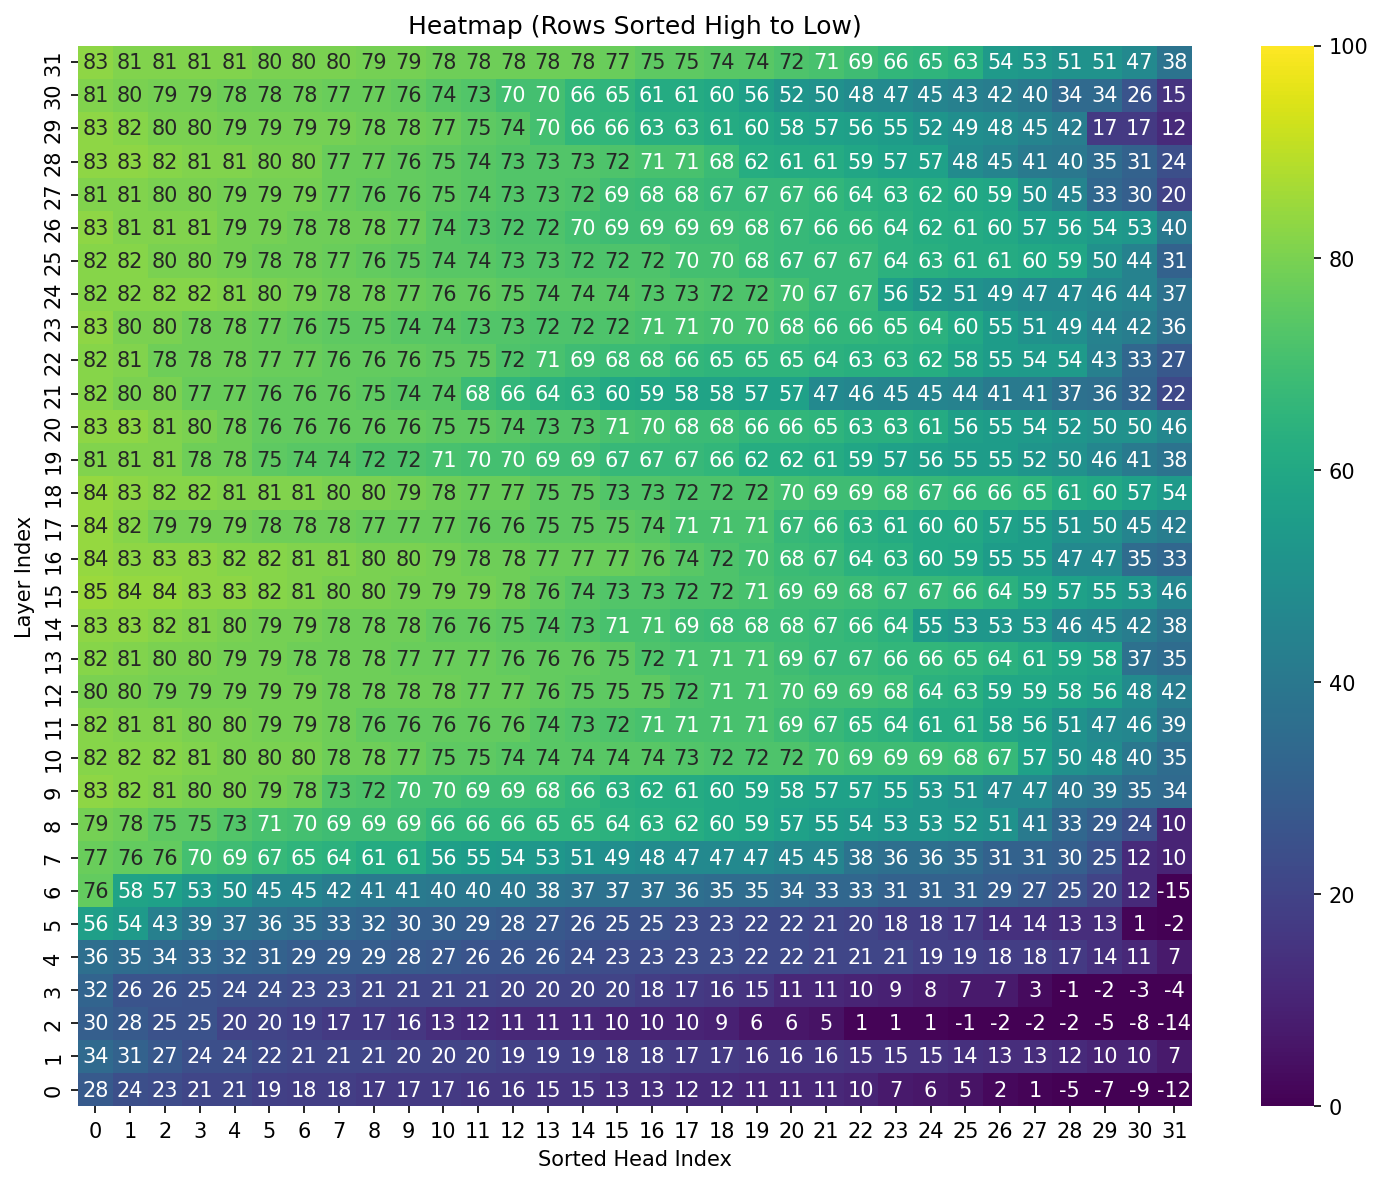

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

Saved features to results/llama-3.1-8b-instruct/politician_features.pkl


Layers:   0%|          | 0/32 [00:00<?, ?it/s]

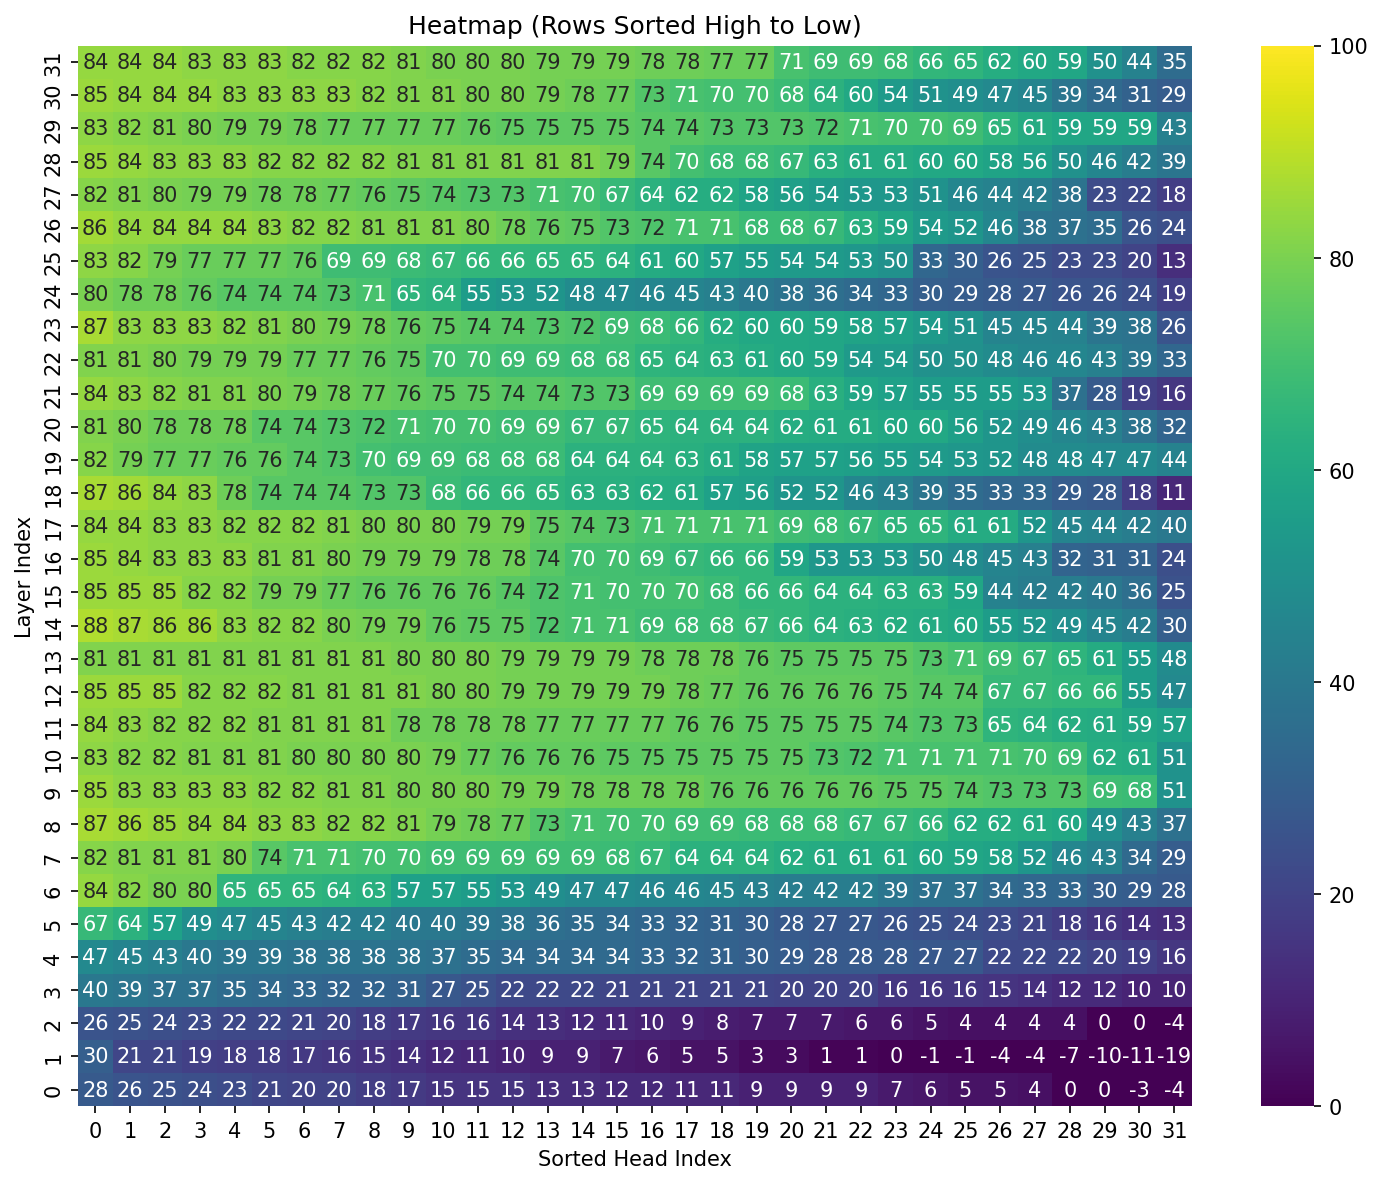

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

Saved features to results/qwen2.5-7b-instruct/politician_features.pkl


Layers:   0%|          | 0/28 [00:00<?, ?it/s]

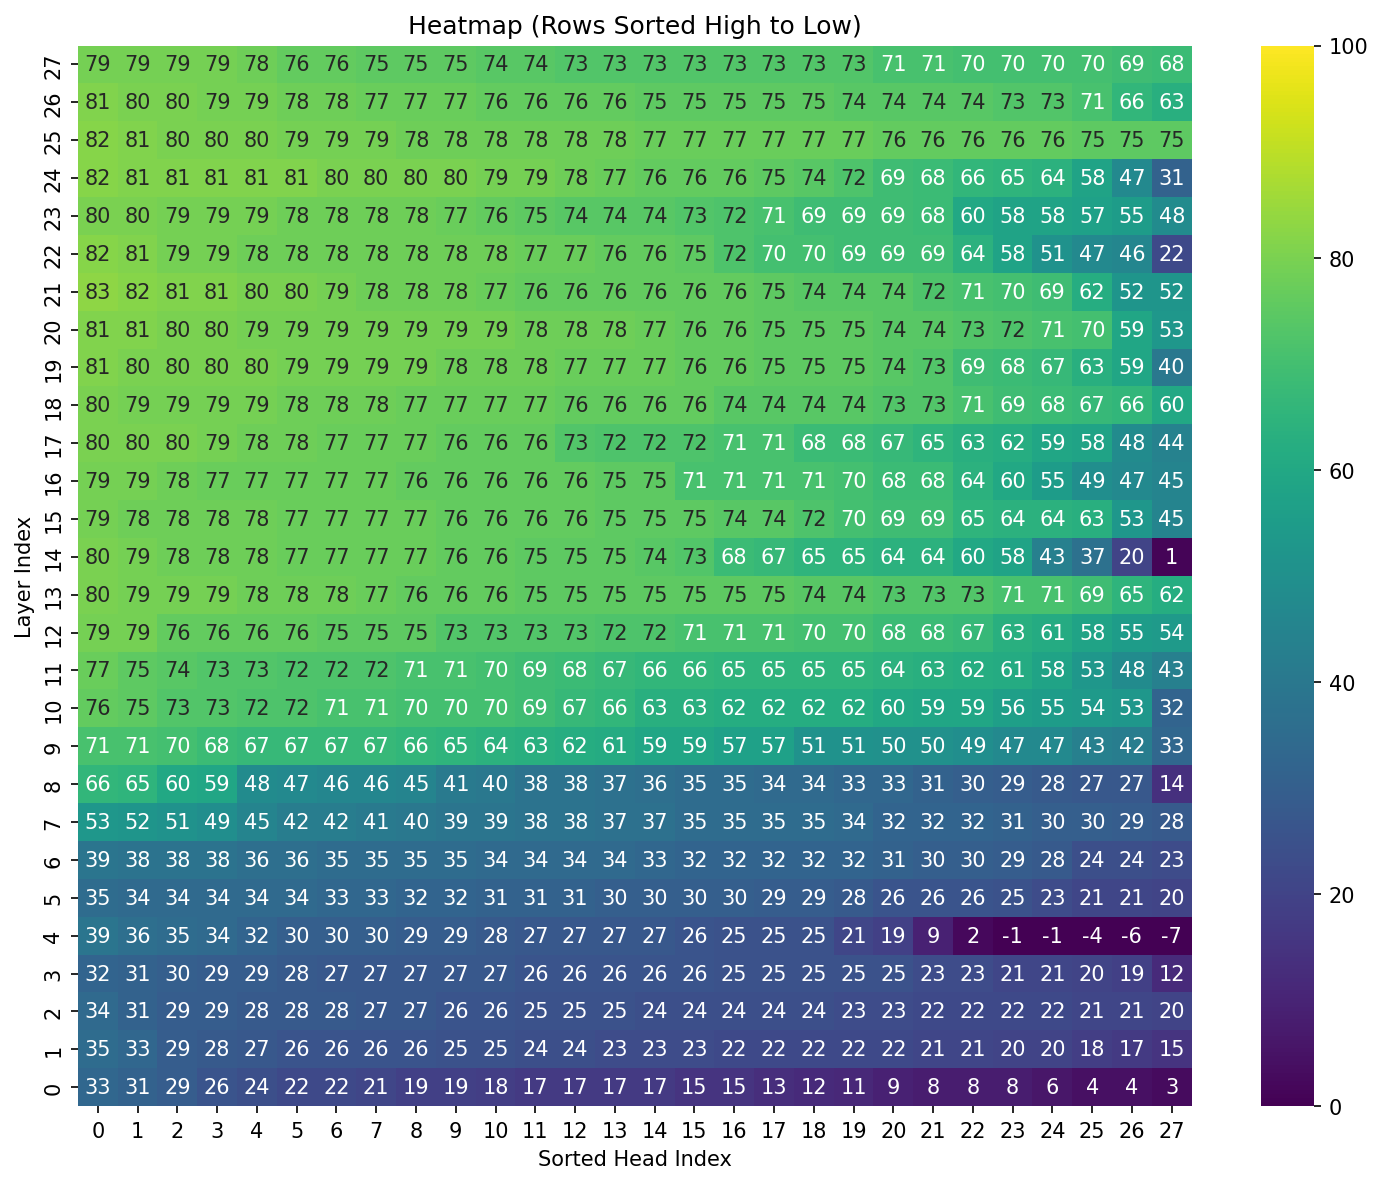

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

Saved features to results/qwen2.5-14b-instruct/politician_features.pkl


Layers:   0%|          | 0/48 [00:00<?, ?it/s]

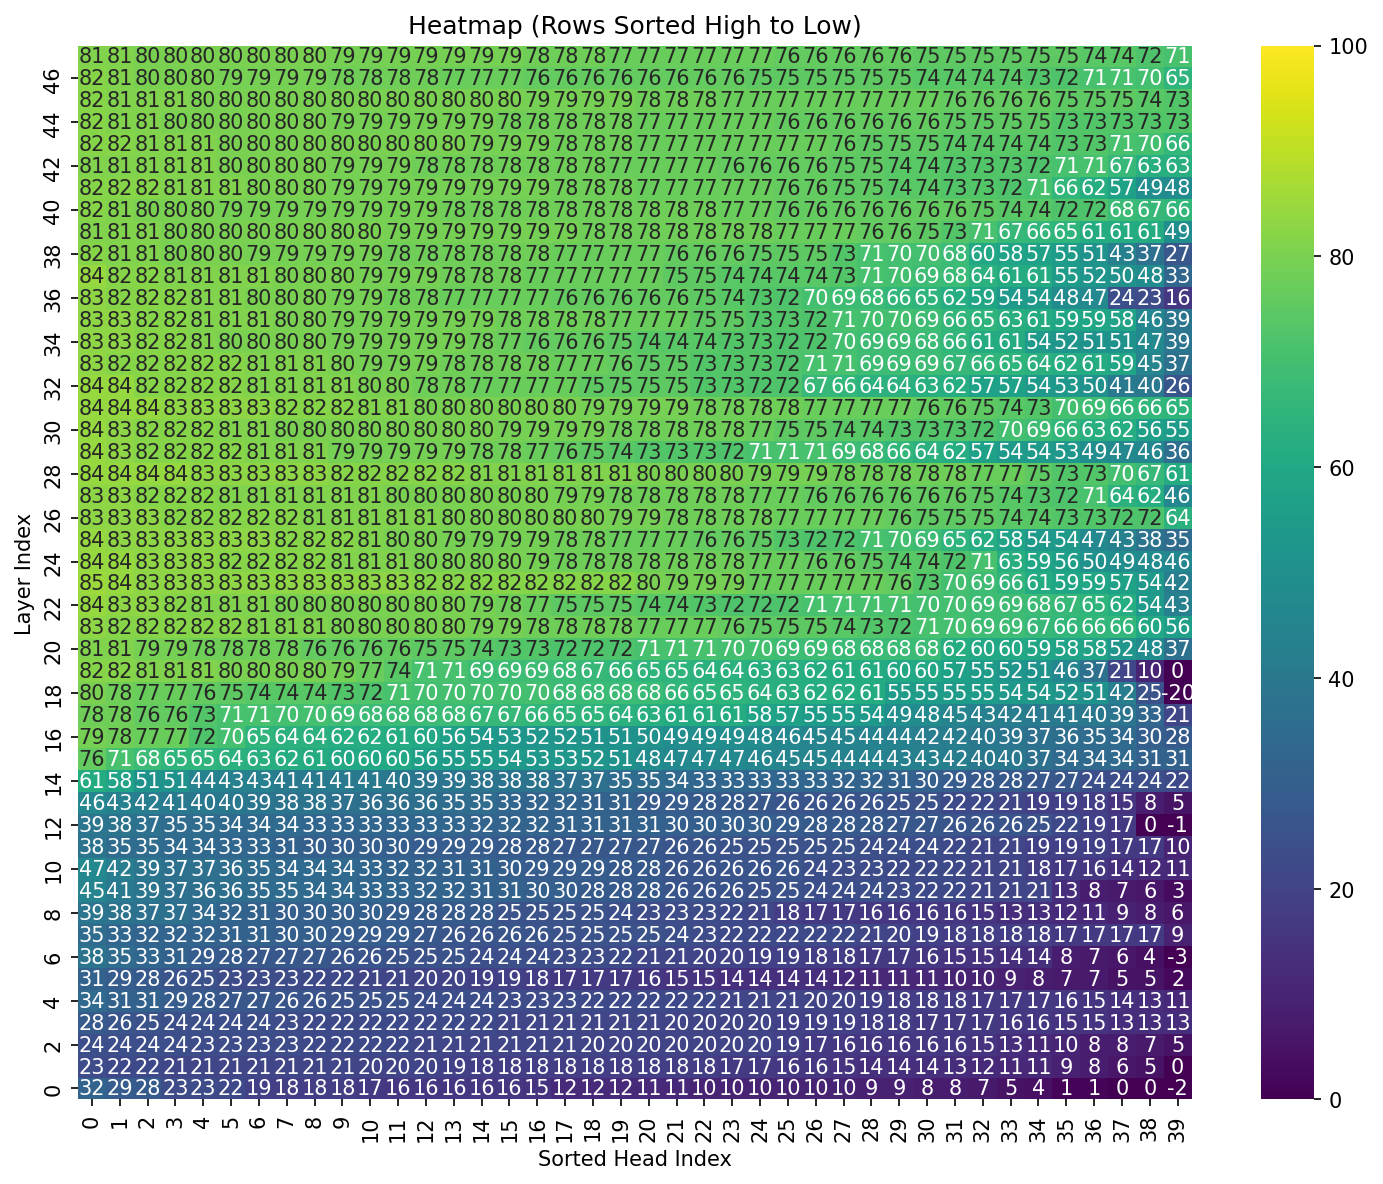

In [16]:
for model_path in MODELS:
    probe_heads(
        model_path=model_path,
        df_prompts=df_prompts_politicians,
        prefix="politician",
        device=device,
        alpha=1.0,
        n_splits=2,
        seed=42,
        data_dir="results",
        figsize=(10, 8),
        dpi=150,
        cmap='viridis',
        vmin=0,
        vmax=100
    )

### Given Voting decisions

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Saved features to results/llama-2-7b-chat-hf/given_vote_features.pkl


Layers:   0%|          | 0/32 [00:00<?, ?it/s]

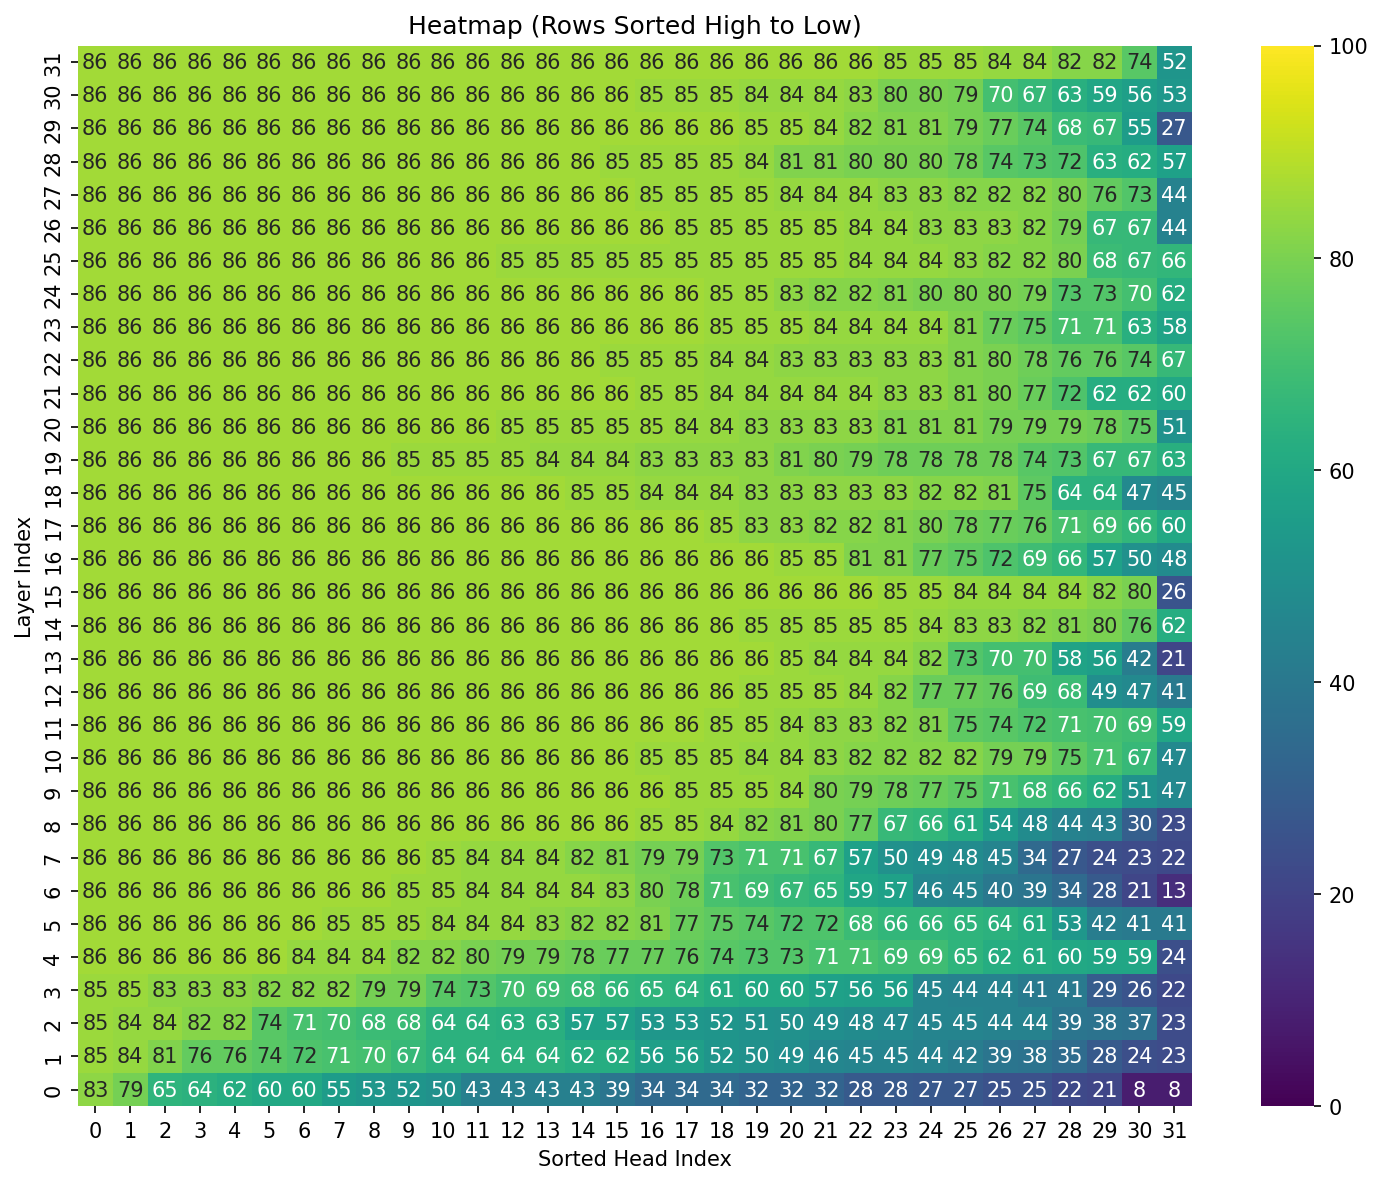

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Saved features to results/llama-3.1-8b-instruct/given_vote_features.pkl


Layers:   0%|          | 0/32 [00:00<?, ?it/s]

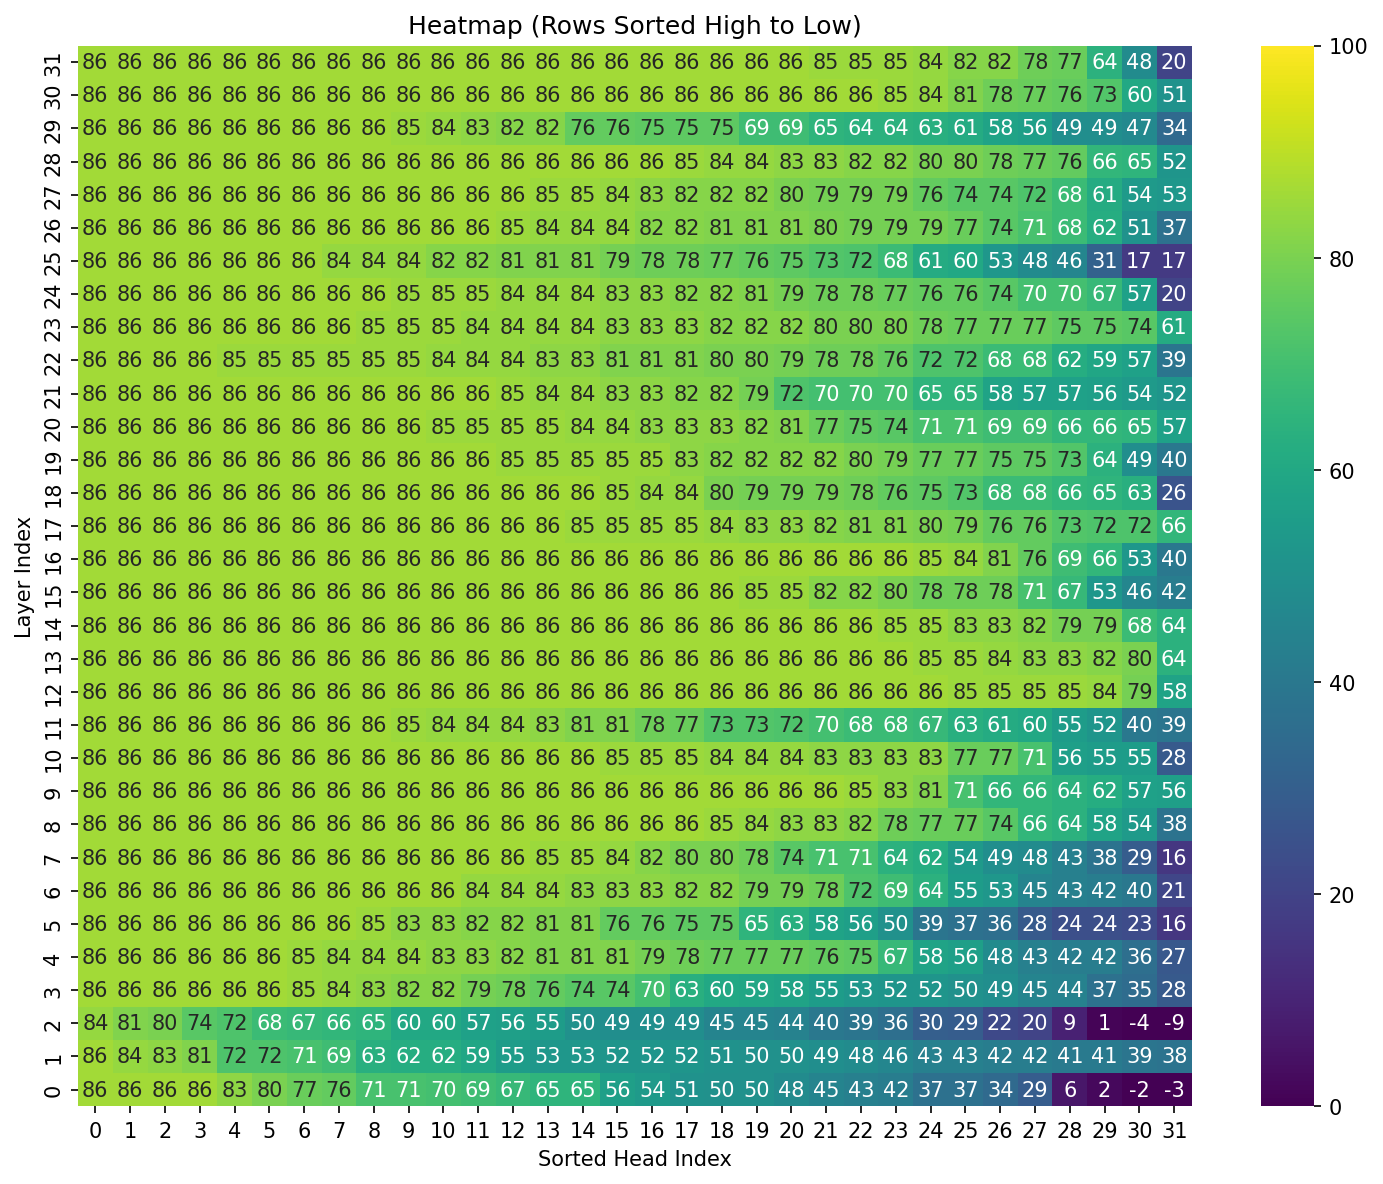

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Saved features to results/qwen2.5-7b-instruct/given_vote_features.pkl


Layers:   0%|          | 0/28 [00:00<?, ?it/s]

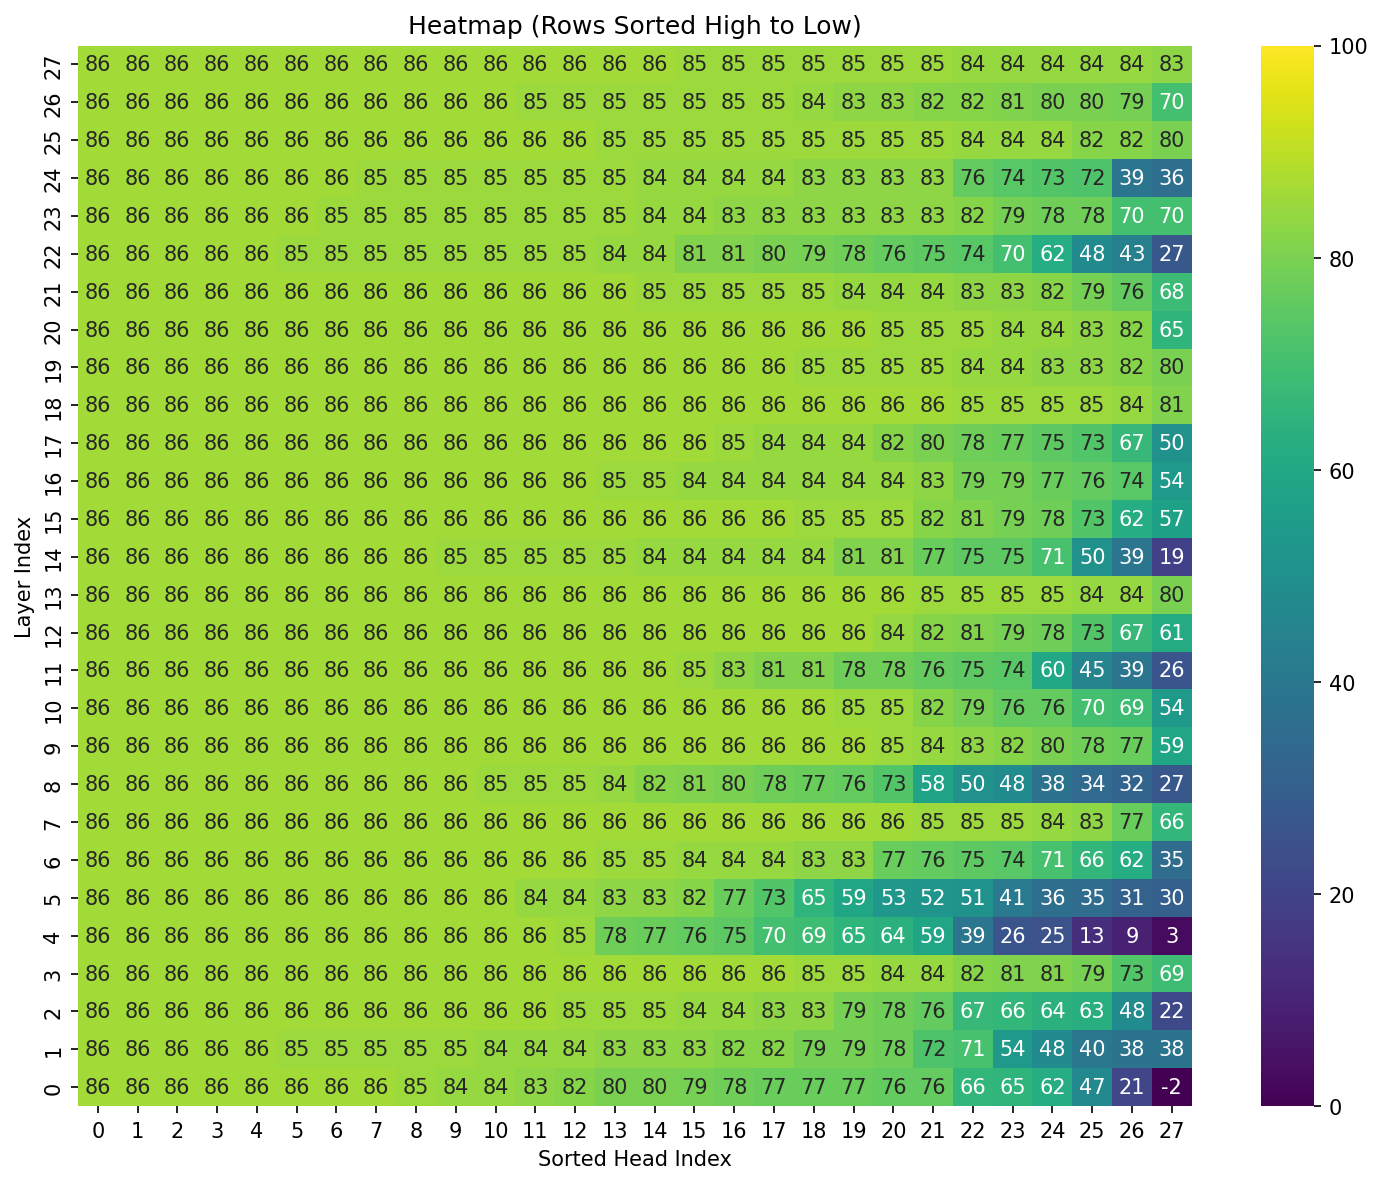

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Saved features to results/qwen2.5-14b-instruct/given_vote_features.pkl


Layers:   0%|          | 0/48 [00:00<?, ?it/s]

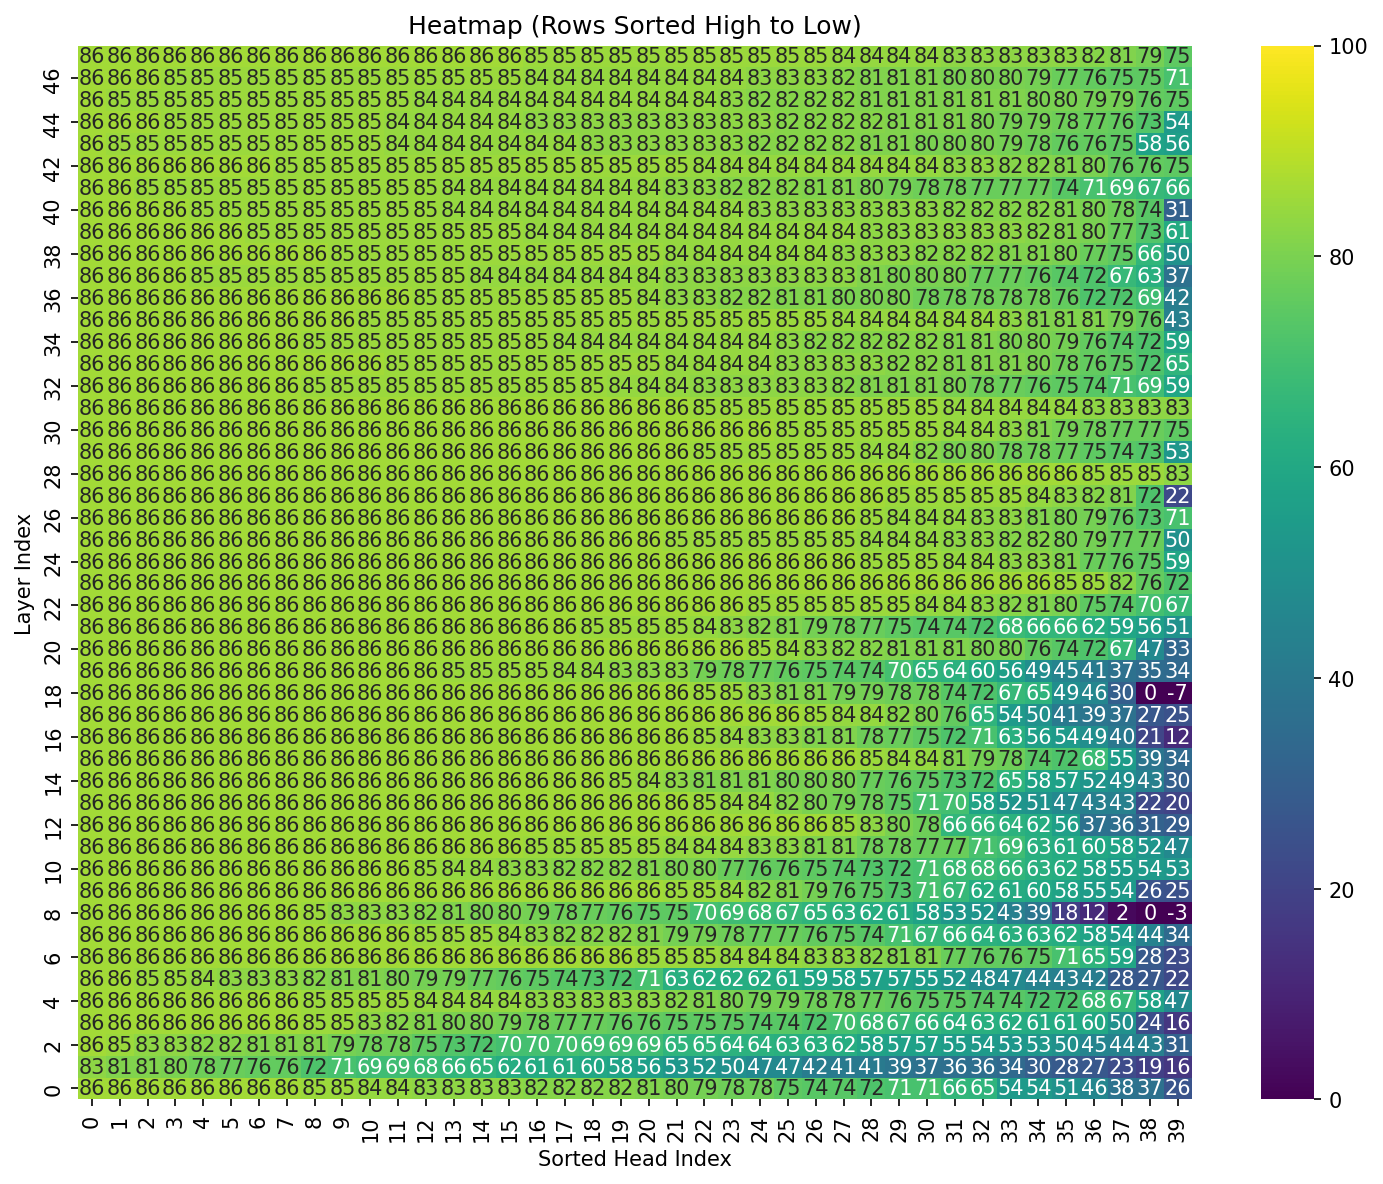

In [17]:
for model_path in MODELS:
    probe_heads(
        model_path=model_path,
        df_prompts=df_prompts_vote,
        prefix="given_vote",
        device=device,
        alpha=1.0,
        n_splits=2,
        seed=42,
        data_dir="results",
        figsize=(10, 8),
        dpi=150,
        cmap='viridis',
        vmin=0,
        vmax=100
    )

In [24]:
_, performance_politician = load_ridge_models(MODELS[0], "politician")
performance_politician

array([[ 0.17007187,  0.11210579,  0.05948115, ...,  0.2878776 ,
         0.1356719 ,  0.17992218],
       [ 0.27817131,  0.19050782,  0.17367346, ...,  0.24959616,
         0.19385225,  0.1082327 ],
       [ 0.10970688,  0.28598701,  0.05008841, ...,  0.2024829 ,
         0.17474552, -0.0189736 ],
       ...,
       [ 0.42397495,  0.60461997,  0.79927358, ...,  0.66662233,
         0.78487884,  0.74267252],
       [ 0.48205889,  0.78811898,  0.73431653, ...,  0.76650554,
         0.65989026,  0.70010119],
       [ 0.74025115,  0.71252317,  0.79678301, ...,  0.74496603,
         0.69915625,  0.78427666]], shape=(32, 32))

In [23]:
_, performance_given_vote = load_ridge_models(MODELS[0], "given_vote")
performance_given_vote

array([[0.43413335, 0.22679931, 0.2167005 , ..., 0.83241977, 0.27023963,
        0.32555183],
       [0.67750706, 0.24784493, 0.46971047, ..., 0.6492535 , 0.44446344,
        0.56850154],
       [0.52937827, 0.84406039, 0.49268335, ..., 0.5311128 , 0.57501566,
        0.44858776],
       ...,
       [0.68621825, 0.67060748, 0.86479765, ..., 0.81931444, 0.86479765,
        0.86433511],
       [0.84413748, 0.8612515 , 0.86437365, ..., 0.80809782, 0.8062862 ,
        0.86479765],
       [0.86479765, 0.84679709, 0.86479765, ..., 0.86479765, 0.86479765,
        0.86352566]], shape=(32, 32))

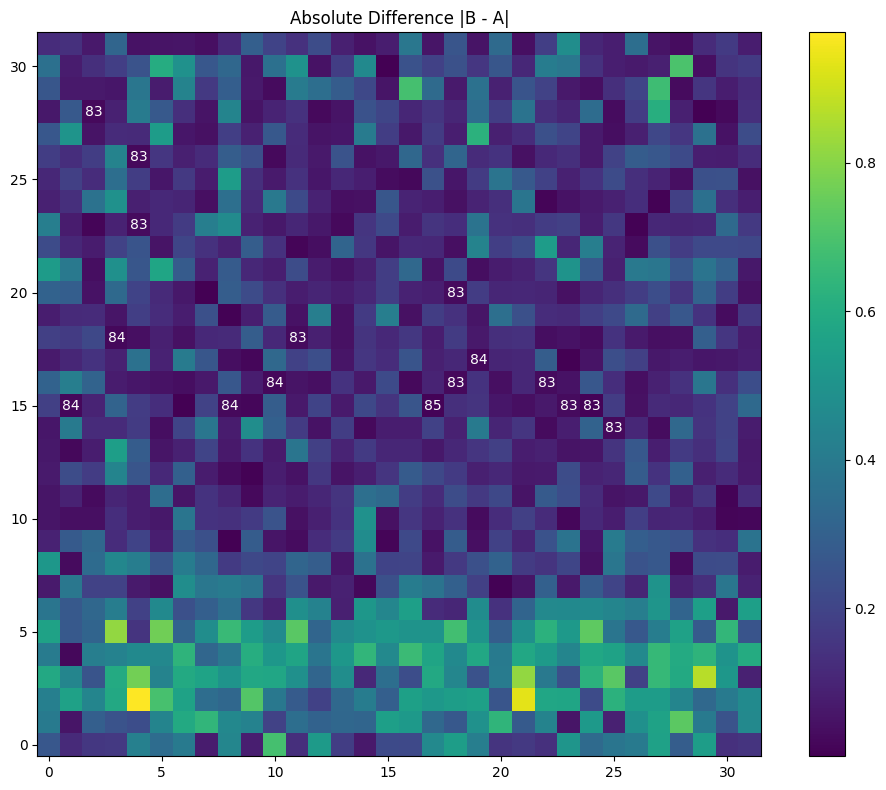

In [38]:
abs_diff = np.abs(performance_politician - performance_given_vote)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(abs_diff)

# Invert y-axis if you want
ax.invert_yaxis()

top_idx = topk_head_indices(performance_politician, k=16)

# Add numbers from performance_politician
for i, j in top_idx:
    ax.text(
        j, i,                           # column, row
        f"{int(performance_politician[i, j] * 100)}",  # format value with 2 decimals
        ha="center", va="center",       # center text
        color="white" if abs_diff[i, j] < abs_diff.max()/2 else "black"  
        # pick text color based on background contrast
    )

ax.set_title("Absolute Difference |B - A|")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
model_paths = [
    "/project/jevans/tzhang3/models/Llama-2-7b-chat-hf",
    "/project/jevans/tzhang3/models/Llama-3.1-8B-Instruct",
    "/project/jevans/tzhang3/models/Qwen2.5-7B-Instruct",
    "/project/jevans/tzhang3/models/Qwen2.5-14B-Instruct"
]

results = generate_and_score_tokens(
    model_path=model_paths[0],
    prompts=prompts_vote,
    max_new_tokens=64,
    hf_token=None,
    k=8,
    candidate_answers=None,
    output_only=False,
    ridge_prefix="given_vote",
    visualize=True,
    device=device
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

[{'features': array([[[[-7.7105e-04, -1.9150e-02, -1.9379e-03, ..., -1.4130e-02,
             4.4174e-03, -7.1411e-03],
           [-3.0308e-03,  1.7571e-04, -6.9847e-03, ...,  6.5613e-04,
             9.3613e-03, -1.0689e-02],
           [ 1.5459e-03, -1.0994e-02,  7.7362e-03, ...,  6.1722e-03,
             7.5197e-04, -6.7711e-03],
           ...,
           [-6.6223e-03, -7.9269e-03,  4.8828e-03, ...,  2.4261e-02,
             2.6794e-02, -3.2139e-03],
           [ 1.4854e-02, -1.3443e-02, -7.7286e-03, ...,  1.4992e-03,
            -2.6901e-02, -7.2289e-03],
           [-3.0880e-03, -4.9133e-03,  3.6983e-03, ...,  2.3861e-03,
             6.9351e-03,  1.1711e-02]],
  
          [[ 7.1411e-02, -3.5591e-03, -2.7008e-02, ..., -3.9368e-03,
            -1.4824e-02, -9.7733e-03],
           [ 3.6907e-03,  2.1687e-03, -3.7975e-03, ..., -8.2626e-03,
            -9.5510e-04,  7.0724e-03],
           [-3.8849e-02, -9.0256e-03, -6.5491e-02, ..., -8.1299e-02,
            -7.2144e-02,  7.9224e-0

### DW Vote Dimension

  0%|          | 0/552 [00:00<?, ?it/s]

Saved features to results/llama-3.1-8b-instruct/dw_vote_features.pkl


Layers:   0%|          | 0/32 [00:00<?, ?it/s]

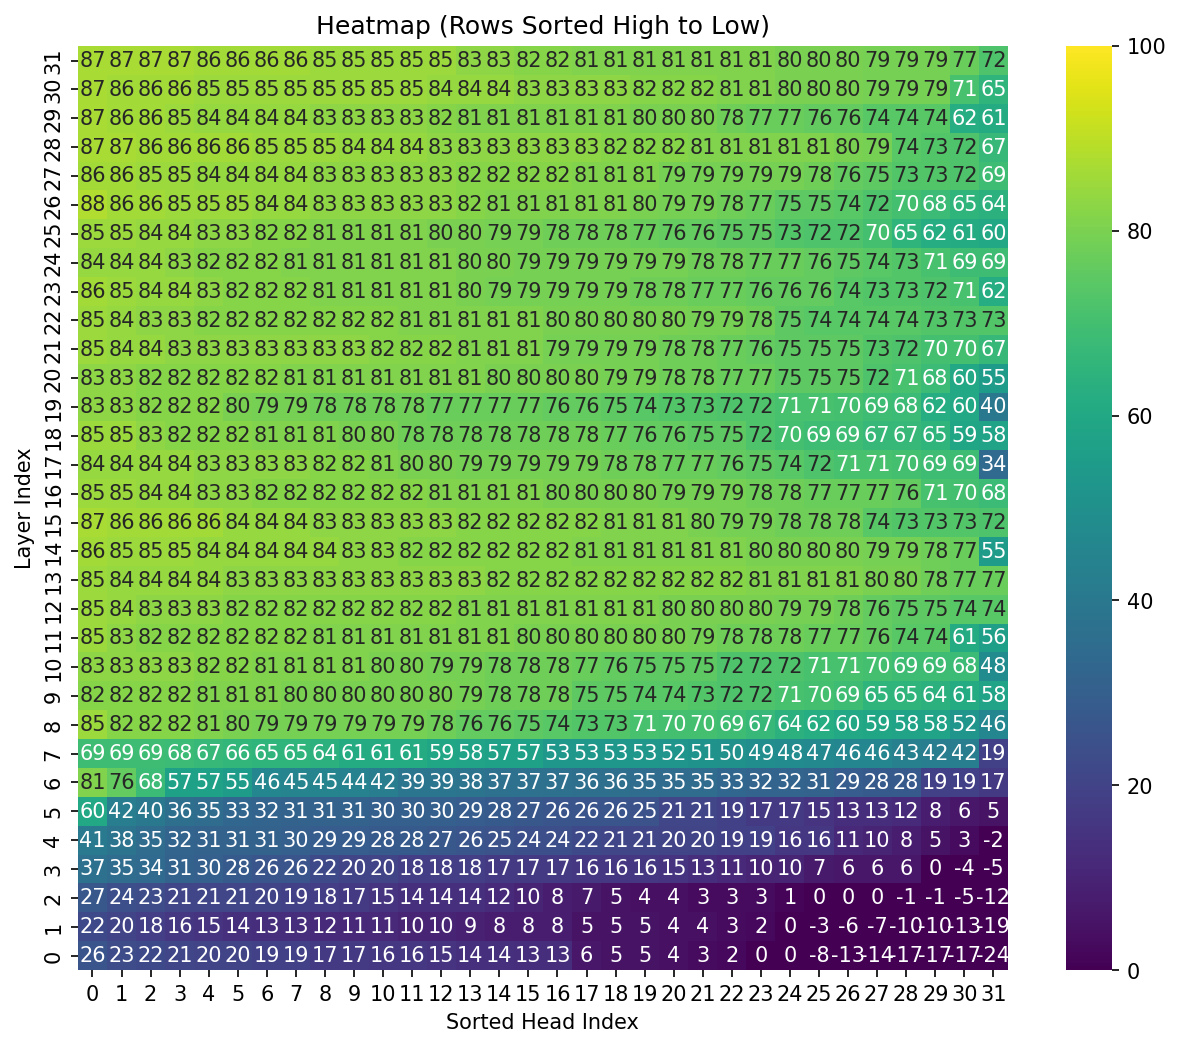

In [ ]:
features = extract_and_save_features(
    model,
    tokenizer,
    model_path,
    df_prompts_dw_vote,
    prefix="dw_vote",
    device=device,
)

performance, ridge_models = train_ridge_models(
    model,
    model_path,
    data_dir="results",
    prefix="dw_vote",
    alpha=1.0,
    n_splits=2,
    seed=SEED
)

ridge_models, performance = load_ridge_models(model_path, "dw_vote")

# Sort each row from high to low
performance_temp = (performance * 100).astype(int)
performance_temp = -np.sort(-performance_temp, axis=1)

plt.figure(figsize=(10, 8), dpi=150)
ax = sns.heatmap(performance_temp, annot=True, cmap='viridis', cbar=True, vmin=0, vmax=100)
ax.invert_yaxis()

plt.title('Heatmap (Rows Sorted High to Low)')
plt.xlabel('Sorted Head Index')
plt.ylabel('Layer Index')
plt.show()


In [ ]:
results_politician = generate_and_score_tokens(
    model_path,
    prompts_vote,
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=64,
    hf_token=None,
    k=8,
    candidate_answers=None,
    output_only=False,
    ridge_prefix="politician",
    device=device
)

  0%|          | 0/20 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a conseque

In [ ]:
visualize_token_scores(results_politician, tokenizer)

In [ ]:
results = generate_and_score_tokens(
    model_path,
    prompts_vote,
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=64,
    hf_token=None,
    k=8,
    candidate_answers=None,
    output_only=False,
    ridge_prefix="dw_vote",
    device=device
)

  0%|          | 0/20 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a conseque

In [ ]:
visualize_token_scores(results, tokenizer)

### DW Vote Steering

In [ ]:
import pandas as pd
from itertools import product
from tqdm import tqdm

def run_head_interventions(
    model_path,
    prompts,
    meta,
    device="cpu",
    alphas=None,
    ks=None,
    prefix="dw_vote",
    results_dir="./results",
    max_new_tokens=3,
    output_csv=None,
):
    """
    Run head‐intervention experiments across combinations of alpha and k,
    parse the model outputs, and return a DataFrame of results (and optionally save to CSV).

    Args:
        model_path (str): Path to your model checkpoint directory.
        model: Your loaded model object.
        tokenizer: Your tokenizer instance.
        prompts (List[str]): List of input prompts to generate from.
        meta (List[dict]): Parallel list of metadata dicts (must contain 'prompt_id' and 'alignment').
        device (torch.device or str): Device to run on, e.g. 'cuda' or 'cpu'.
        alphas (List[float], optional): List of alpha values to sweep. Defaults to [-30, -20, -10, 0, 10, 20, 30].
        ks (List[int], optional): List of k values to sweep. Defaults to [8, 16, 32, 64, 96].
        prefix (str, optional): Prefix used in naming/loading. Default “dw_vote”.
        results_dir (str, optional): Directory where to save intermediate results. Default “./results”.
        max_new_tokens (int, optional): How many tokens to generate per prompt. Default 3.
        output_csv (str, optional): If provided, path where a CSV will be written.
    
    Returns:
        pd.DataFrame: DataFrame with one row per (prompt, α, k) sample, including parsed labels.
    """
    if alphas is None:
        alphas = [-30, -20, -10, 0, 10, 20, 30]
    if ks is None:
        ks = [8, 16, 32, 64, 96]

    tokenizer, model = load_tokenizer_and_model(model_path, device=device)

    all_results = []
    base_name = model_base_name(model_path)

    # Pre-load ridge models & performance once per (α, k) combo
    for alpha, k in tqdm(product(alphas, ks), total=len(alphas) * len(ks)):
        ridge_models, performance = load_ridge_models(model_path, prefix)
        coefs = compute_combined_coefs(
            model_path=model_path,
            k=k,
            ridge_models=ridge_models,
            performance=performance,
            prefix=prefix,
            results_dir=results_dir,
            device=device,
        )

        results = generate_with_head_intervention_gpu(
            model=model,
            tokenizer=tokenizer,
            prompts=prompts,
            alpha=alpha,
            max_new_tokens=max_new_tokens,
            combined_coefs=coefs,
            return_features=False,
            device=device,
        )

        # Annotate
        for i, res in enumerate(results):
            res.update({
                "prompt_id": meta[i]["prompt_id"],
                "alignment": meta[i]["alignment"],
                "k": k,
                "alpha": alpha
            })
            all_results.append(res)

    # Build DataFrame
    df = pd.DataFrame(all_results)

    del model
    clean_up(device=device)

    # Function to parse answer text into label
    def _parse_label(answer):
        txt = answer.split("ASSISTANT", 1)[-1].lower()
        if "either" in txt or "neither" in txt:
            return 0
        if "joe" in txt or "biden" in txt:
            return -1
        if "donald" in txt or "trump" in txt:
            return 1

        # fallback
        return 0

    df["parsed_label"] = df["answer"].apply(_parse_label)

    # Optionally save
    if output_csv:
        out_path = output_csv
    else:
        out_path = f"{results_dir}/{base_name}/{prefix}_intervention_votes.csv"
    df.to_csv(out_path, index=False)
    print(f"Results written to {out_path}")

    return df

In [30]:
for model_path in MODELS:
    df_results = run_head_interventions(
        model_path=model_path,
        prompts=prompts_vote,
        meta=meta_vote,
        prefix="given_vote",
        device=device,
        alphas=[-30, -20, -15, -10, -5, 0, 5, 10, 15, 20, 30]
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 55/55 [03:35<00:00,  3.92s/it]


Results written to ./results/llama-2-7b-chat-hf/given_vote_intervention_votes.csv


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 fo

Results written to ./results/llama-3.1-8b-instruct/given_vote_intervention_votes.csv


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 55/55 [03:28<00:00,  3.79s/it]


Results written to ./results/qwen2.5-7b-instruct/given_vote_intervention_votes.csv


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 55/55 [05:47<00:00,  6.33s/it]


Results written to ./results/qwen2.5-14b-instruct/given_vote_intervention_votes.csv


In [37]:
import numpy as np

for model_path in MODELS:
    model_base = model_base_name(model_path)
    print(model_base)
    csv_file = os.path.join("results", model_base, "given_vote_intervention_votes.csv")
    df_results = pd.read_csv(csv_file)

    df_label_counts = (
        df_results
        .groupby(["k", "alpha", "parsed_label"])
        .size()
        .unstack(fill_value=0)                  # columns: [-1], [0], [1]
        .rename(columns={-1: "neg_count", 0: "no_response", 1: "pos_count"})
        .reset_index()
    )

    # total prompts per (k, alpha)
    df_label_counts["total"] = (
        df_label_counts["neg_count"]
        + df_label_counts["pos_count"]
        + df_label_counts["no_response"]
    )

    # response rate = (neg + pos) / total
    df_label_counts["response_rate"] = (
        (df_label_counts["neg_count"] + df_label_counts["pos_count"])
        / df_label_counts["total"]
    )

    # positive‐to‐negative ratio
    df_label_counts["pos_neg_ratio"] = (
        df_label_counts["pos_count"]
        / df_label_counts["neg_count"].replace(0, np.nan)
    )

    for k_val in df_label_counts["k"].unique():
        sub = df_label_counts[(df_label_counts["k"] == k_val) & (df_label_counts["response_rate"] >= 0.8)]
        corr = sub[["alpha", "pos_neg_ratio"]].corr().iloc[0, 1]
        print(f"k={k_val}  corr(α, pos/neg) = {corr:.3f}")


    output_dir = os.path.join("results", model_base, "given_vote_intervention_votes_count.csv")
    df_label_counts.to_csv(output_dir)


llama-2-7b-chat-hf
k=8  corr(α, pos/neg) = 0.734
k=16  corr(α, pos/neg) = 0.545
k=32  corr(α, pos/neg) = 0.781
k=64  corr(α, pos/neg) = 0.977
k=96  corr(α, pos/neg) = 0.999
llama-3.1-8b-instruct
k=8  corr(α, pos/neg) = 0.754
k=16  corr(α, pos/neg) = 0.762
k=32  corr(α, pos/neg) = 0.864
k=64  corr(α, pos/neg) = 0.759
k=96  corr(α, pos/neg) = 0.576
qwen2.5-7b-instruct
k=8  corr(α, pos/neg) = 0.560
k=16  corr(α, pos/neg) = 0.713
k=32  corr(α, pos/neg) = 0.434
k=64  corr(α, pos/neg) = 0.312
k=96  corr(α, pos/neg) = -0.127
qwen2.5-14b-instruct
k=8  corr(α, pos/neg) = -0.597
k=16  corr(α, pos/neg) = 0.240
k=32  corr(α, pos/neg) = -0.761
k=64  corr(α, pos/neg) = -0.480
k=96  corr(α, pos/neg) = -0.184


### Vote Steering

#### Setup

In [19]:
model_path = MODELS[2]
base_name = model_base_name(model_path)

#### Steering

In [48]:
tokenizer, model = load_tokenizer_and_model(model_path, device=device)

all_results = []
alphas = [-30, -20, -10, 0, 10, 20, 30]
ks     = [8, 16, 32, 64, 96]

# wrap the outer loops in a single tqdm over the product
for alpha, k in tqdm(product(alphas, ks), total=len(alphas)*len(ks)):
    # load your ridge models & performance once per combo
    ridge_models, performance = load_ridge_models(model_path, "politician")

    coefs = compute_combined_coefs(
        model_path=model_path,
        k=k,
        ridge_models=ridge_models,
        performance=performance,
        prefix="politician",
        results_dir="./results",
        device=device
    )

    # now generate for all prompts
    results = generate_with_head_intervention_gpu(
        model=model,
        tokenizer=tokenizer,
        prompts=prompts_vote,
        alpha=alpha,
        max_new_tokens=3,
        combined_coefs=coefs,
        return_features=False,
        device=device
    )

    # annotate and collect
    for i, res in enumerate(results):
        res["prompt_id"] = i
        res["alignment"] = meta_vote[i]['alignment']
        res["k"]         = k
        res["alpha"]     = alpha
        all_results.append(res)

# finally dump to CSV
df_res = pd.DataFrame(all_results)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [49]:
def _parse_labels(answer):
    answer = answer.split("ASSISTANT", 2)[-1].lower()[:60]
    if "joe" in answer or "biden" in answer:
        return -1
    if "donald" in answer or "trump" in answer:
        return 1

    print(f"Unknown label: {answer}")
    return 0

base_name = model_base_name(model_path)
df_res['parsed_label'] = df_res['answer'].apply(_parse_labels)
df_res.dropna().to_csv(
    f"./results/{base_name}/politician_intervention_votes.csv",
    index=False
)

Unknown label: : as a conservative, i would vote for the platform that
Unknown label: : as a liberal, i would vote for the candidate who
Unknown label: : as a conservative, i would vote for the platform that
Unknown label: : as a conservative, i would vote for the platform of


#### Calculate correlation

In [24]:
# Group by k and alpha, then calculate average parsed_label
file_path = f"./results/{base_name}/politician_intervention_votes.csv"
df = pd.read_csv(file_path)
df = df[df["alpha"].abs() <= 20]
grouped = df.groupby(["k", "alpha"])["parsed_label"].mean().reset_index(name="avg_parsed_label")

# For each k, calculate correlations
results = []
for k_val, group in grouped.groupby("k"):
    if len(group) > 1:  # Need at least 2 points to calculate correlation
        pearson_corr, _ = pearsonr(group["alpha"], group["avg_parsed_label"])
        spearman_corr, _ = spearmanr(group["alpha"], group["avg_parsed_label"])
        results.append({"k": k_val, "pearson_corr": pearson_corr, "spearman_corr": spearman_corr})
    else:
        results.append({"k": k_val, "pearson_corr": None, "spearman_corr": None})

# Convert results to DataFrame
correlation_df = pd.DataFrame(results)
output_dir = f"./results/{base_name}/politician_intervention_corr_votes.csv"
correlation_df.to_csv(output_dir)

correlation_df.head()

k  pearson_corr  spearman_corr
0   8      0.188982       0.210819
1  16      0.416025       0.410391
2  32     -0.566947      -0.527046
3  64     -0.364662      -0.359092
4  96      0.938315       0.974679

#### Plotting

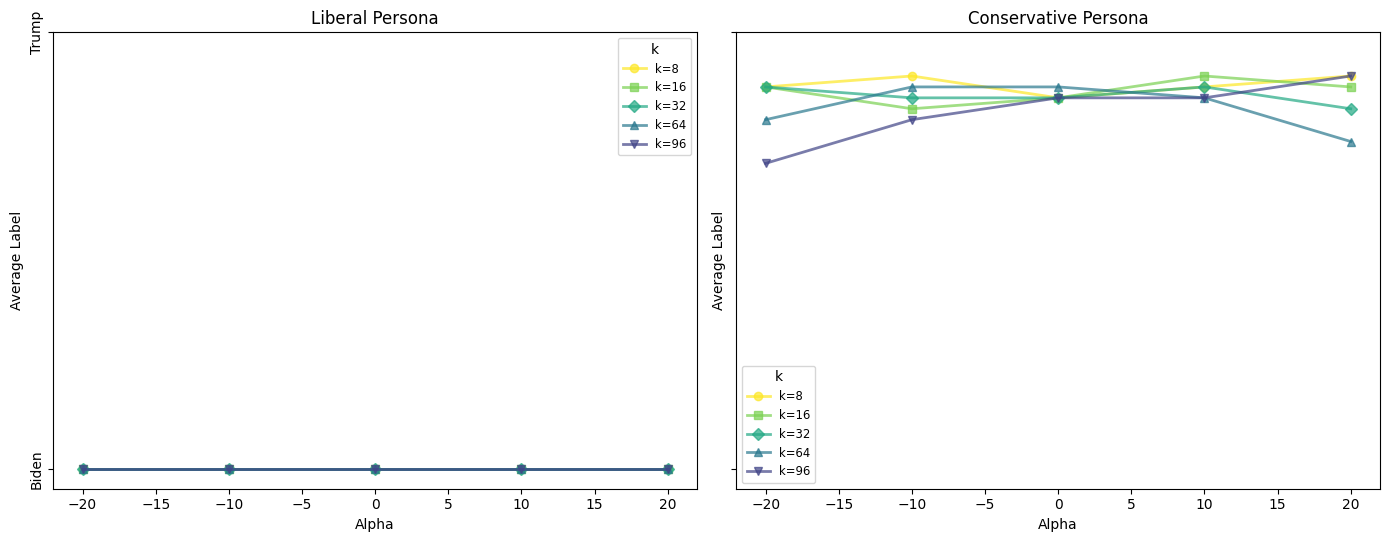

In [79]:
import numpy as np

model_path = MODELS[2]
base_name = model_base_name(model_path)

# Group by k and alpha, then calculate average parsed_label
file_path = f"./results/{base_name}/politician_intervention_votes.csv"
df = pd.read_csv(file_path)
df = df[df["alpha"].abs() <= 20]
df_res = df

# Re-plot with custom y-axis ticks and labels
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
alignment_groups = ['liberal', 'conservative']
colors = plt.cm.viridis_r
markers = ['o', 's', 'D', '^', 'v', '*', 'x']
k_vals = sorted(df_res['k'].unique())

for ax, alignment in zip(axes, alignment_groups):
    sub_df = df_res[df_res['alignment'] == alignment]
    
    for i, (k_val, group) in enumerate(sub_df.groupby('k')):
        avg_label_by_alpha = group.groupby('alpha')['parsed_label'].mean().sort_index()
        ax.plot(
            avg_label_by_alpha.index,
            avg_label_by_alpha.values,
            label=f'k={k_val}',
            color=colors(i / len(k_vals)),
            linewidth=2,
            alpha=0.7,
            marker=markers[i % len(markers)]
        )
    
    ax.set_title(f"{alignment.capitalize()} Persona")
    ax.set_xlabel("Alpha")
    ax.set_ylabel("Average Label")
    ax.set_yticks([-1, 1])
    ax.set_yticklabels(["Biden", "Trump"], rotation=90, va="center")
    ax.legend(title="k", fontsize='small')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
os.makedirs(f"./figs/{base_name}/", exist_ok=True)
plt.savefig(f"./figs/{base_name}/vote_intervention_plot.pdf", bbox_inches='tight')
plt.show()


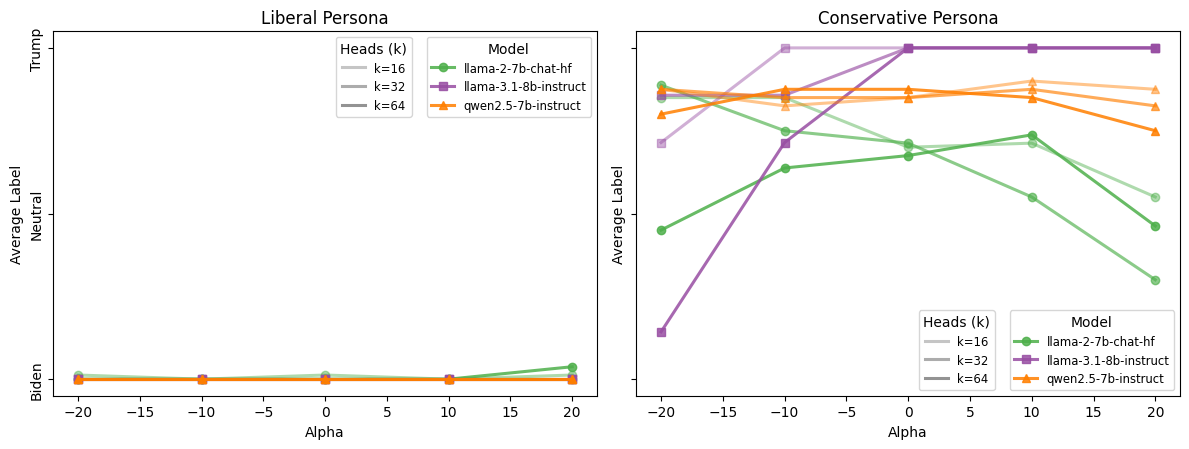

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os

# --- Load and concat results for MODELS[0], MODELS[1], MODELS[2]
all_results = []
model_order = []
for midx in [0, 1, 2]:
    model_path = MODELS[midx]
    base_name = model_base_name(model_path)
    model_order.append(base_name)

    file_path = f"./results/{base_name}/politician_intervention_votes.csv"
    df = pd.read_csv(file_path)
    df = df[df["alpha"].abs() <= 20]
    df = df[df["k"].isin([16, 32, 64])]  # keep three k's
    df["model_name"] = base_name
    all_results.append(df)

df_res = pd.concat(all_results, ignore_index=True)

# --- Styling
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
alignment_groups = ["liberal", "conservative"]

# Distinct colors per model (consistent ordering)
cmap = plt.cm.Set1
model_colors = {name: cmap(i + 2) for i, name in enumerate(model_order)}

# Distinct markers per model
marker_map_model = {name: m for name, m in zip(model_order, ["o", "s", "^"])}

# Transparency encodes k
alpha_map = {16: 0.45, 32: 0.65, 64: 0.85}

for ax, alignment in zip(axes, alignment_groups):
    sub_df = df_res[df_res["alignment"] == alignment]

    # Plot three lines per model (k=16,32,64)
    for model_name, g_model in sub_df.groupby("model_name"):
        color = model_colors[model_name]
        marker = marker_map_model[model_name]
        for k_val in [16, 32, 64]:
            g_k = g_model[g_model["k"] == k_val]
            if g_k.empty:
                continue
            avg_label_by_alpha = (
                g_k.groupby("alpha")["parsed_label"].mean().sort_index()
            )
            ax.plot(
                avg_label_by_alpha.index,
                avg_label_by_alpha.values,
                label=model_name if k_val == 64 else None,  # one legend entry per model
                color=color,
                linewidth=2.2,
                alpha=alpha_map[k_val],
                marker=marker
            )

    ax.set_title(f"{alignment.capitalize()} Persona")
    ax.set_xlabel("Alpha")
    ax.set_ylabel("Average Label")
    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels(["Biden", "Neutral", "Trump"], rotation=90, va="center")

    # Legends: (1) Model colors/markers, (2) k via opacity
    # (1) Model legend from plotted handles
    if alignment == "liberal":
        upper = "upper"
    else:
        upper = "lower"

    handles1, labels1 = ax.get_legend_handles_labels()
    legend1 = ax.legend(handles1, labels1, title="Model", fontsize="small", loc=f"{upper} right")
    ax.add_artist(legend1)

    if alignment == "liberal":
        bbox = (0.67, 1)
    else:
        bbox = (0.67, 0)

    # (2) k legend via proxy handles (same shape/color, only alpha difference)
    k_proxies = [
        Line2D([0], [0], color="gray", alpha=alpha_map[k], linewidth=2.2, label=f"k={k}")
        for k in [16, 32, 64]
    ]
    ax.legend(handles=k_proxies, title="Heads (k)", fontsize="small", loc=f"{upper} right", bbox_to_anchor=bbox)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
os.makedirs("./figs", exist_ok=True)
plt.savefig("./figs/vote_intervention_models.pdf", bbox_inches="tight")
plt.show()


### Bias Detection Steering

#### Setup

In [28]:
model_path = MODELS[0]
prefix = "politician"
results_dir = "results"
prompts = prompts_bias
max_new_tokens = 12

base_name = model_base_name(model_path)

#### Steering

In [31]:
# 1) Load tokenizer/model once
tokenizer, model = load_tokenizer_and_model(model_path, device=device)

# 2) Load feats, ridge models, and performance once
feats = load_feats(model_path=model_path, prefix=prefix, results_dir=results_dir, device=device)
ridge_models, performance = load_ridge_models(model_path, prefix)

alphas = [0]
ks = [8, 16, 32, 64, 96]

all_results = []

for alpha, k in tqdm(product(alphas, ks), total=len(alphas) * len(ks)):
    # 3) Build combined coefs for this k (selection uses performance)
    coefs = compute_combined_coefs(
        feats=feats,
        ridge_models=ridge_models,
        k=k,
        performance=performance,
        device=device,
    )

    # 4) Run intervention generation
    results = generate_with_head_intervention_gpu(
        model=model,
        tokenizer=tokenizer,
        prompts=prompts,
        alpha=alpha,
        max_new_tokens=max_new_tokens,
        combined_coefs=coefs,
        return_features=False,
        device=device,
    )

    # Annotate
    for i, res in enumerate(results):
        res.update({
            "prompt_id": i,
            "k": k,
            "alpha": alpha
        })
        all_results.append(res)

# Build DataFrame
df = pd.DataFrame(all_results)

del model
clean_up(device=device)

# Function to parse answer text into label
def _parse_label(answer):
    answer = answer.split("ASSISTANT", 2)[-1]
    if "neutral" in answer or "neither" in answer or "moderate" in answer or "centrist" in answer or "center" in answer or "balanced" in answer or "not biased" in answer:
        return 0

    if "left" in answer or "liberal" in answer or "progressive" in answer:
        if "slight" in answer:
            return -1

        return -2

    if "right" in answer or "conservative" in answer:
        if "slight" in answer:
            return 1

        return 2

    print(f"Unknown label: {answer}")
    return 0

df["parsed_label"] = df["answer"].apply(_parse_label)


out_path = f"{results_dir}/{base_name}/{prefix}_intervention_bias.csv"
df.to_csv(out_path, index=False)
print(f"Results written to {out_path}")

df

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

Results written to results/llama-2-7b-chat-hf/politician_intervention_bias.csv


answer  prompt_id   k  alpha  \
0     USER: In the context of 2019 U.S. politics, is...          0   8      0   
1     USER: In the context of 2019 U.S. politics, is...          1   8      0   
2     USER: In the context of 2019 U.S. politics, is...          2   8      0   
3     USER: In the context of 2019 U.S. politics, is...          3   8      0   
4     USER: In the context of 2019 U.S. politics, is...          4   8      0   
...                                                 ...        ...  ..    ...   
1195  USER: In the context of 2019 U.S. politics, is...        235  96      0   
1196  USER: In the context of 2019 U.S. politics, is...        236  96      0   
1197  USER: In the context of 2019 U.S. politics, is...        237  96      0   
1198  USER: In the context of 2019 U.S. politics, is...        238  96      0   
1199  USER: In the context of 2019 U.S. politics, is...        239  96      0   

      parsed_label  
0               -2  
1               -2  
2               -2  
3               -2  
4                2  
...            ...  
1195            -2  
1196             0  
1197             0  
1198            -2  
1199             2  

[1200 rows x 5 columns]

#### Calculate correlation

In [38]:
from scipy.stats import pearsonr, spearmanr

# Group by k and alpha, then calculate average parsed_label
file_path = os.path.join(results_dir, base_name, f"{prefix}_intervention_bias.csv")
df = pd.read_csv(file_path)
grouped = df.groupby(["k", "alpha"])["parsed_label"].mean().reset_index(name="avg_parsed_label")

# For each k, calculate correlations
results = []
for k_val, group in grouped.groupby("k"):
    if len(group) > 1:  # Need at least 2 points to calculate correlation
        pearson_corr, _ = pearsonr(group["alpha"], group["avg_parsed_label"])
        spearman_corr, _ = spearmanr(group["alpha"], group["avg_parsed_label"])
        results.append({"k": k_val, "pearson_corr": pearson_corr, "spearman_corr": spearman_corr})
    else:
        results.append({"k": k_val, "pearson_corr": None, "spearman_corr": None})

# Convert results to DataFrame
correlation_df = pd.DataFrame(results)
output_dir = os.path.join(results_dir, base_name, f"{prefix}_intervention_corr_bias.csv")
correlation_df.to_csv(output_dir)

correlation_df.head()

k  pearson_corr  spearman_corr
0   8      0.881074       0.857143
1  16      0.425944       0.392857
2  32     -0.545069      -0.142857
3  64      0.935270       0.964286
4  96      0.827412       0.785714

#### Sankey plot

In [41]:
import pandas as pd
import plotly.graph_objects as go

# Load data
file_path = f"results/{base_name}/politician_intervention_bias.csv"
df = pd.read_csv(file_path)

# Filter for k=32 and selected alphas
selected_alphas = [-30, 0, 30]
df_k32 = df[(df['k'] == 64) & (df['alpha'].isin(selected_alphas))]

# Define ordered label levels
label_levels = [-2, -1, 0, 1, 2]

# Count label frequency per alpha
label_counts = {
    alpha: df_k32[df_k32['alpha'] == alpha]['parsed_label']
           .value_counts()
           .reindex(label_levels, fill_value=0)
           .to_dict()
    for alpha in selected_alphas
}

# Compute node positions
node_x, node_y = [], []
for i, alpha in enumerate(selected_alphas):
    x = i / (len(selected_alphas) - 1)
    total = sum(label_counts[alpha].values())
    cum = 0
    for lbl in label_levels:
        cnt = label_counts[alpha][lbl]
        if not cnt:
            continue
        frac = cnt / total
        node_x.append(x)
        node_y.append(1 - (cum + frac/2))
        cum += frac

# Build node labels & index map
nodes = [
    f"α={alpha}, label={lbl}"
    for alpha in selected_alphas
    for lbl in label_levels
    if label_counts[alpha][lbl] > 0
]
node_idx = {n: i for i, n in enumerate(nodes)}

# Map raw labels to category names
category_map = {
    -2: "Liberal",
    -1: "Liberal",
     0: "Neutral",
     1: "Conservative",
     2: "Conservative"
}
# Prepare the node‐label list
node_labels = [
    category_map[int(n.split("label=")[1])]
    for n in nodes
]

# Color map
color_map = {
    -2: "#08306B", -1: "#4292C6",
     0: "#D9D9D9",  1: "#FB6A4A",
     2: "#99000D"
}

# Build and aggregate links
link_dict = {}
for i in range(len(selected_alphas)-1):
    a0, a1 = selected_alphas[i], selected_alphas[i+1]
    d0 = df_k32[df_k32['alpha']==a0].set_index('prompt_id')
    d1 = df_k32[df_k32['alpha']==a1].set_index('prompt_id')
    for pid in d0.index.intersection(d1.index):
        f, t = int(d0.loc[pid,'parsed_label']), int(d1.loc[pid,'parsed_label'])
        s = node_idx[f"α={a0}, label={f}"]
        t = node_idx[f"α={a1}, label={t}"]
        key = (s, t, f)
        link_dict[key] = link_dict.get(key, 0) + 1

src, tgt, val, lcol = [], [], [], []
for (s, t, f), count in link_dict.items():
    src.append(s)
    tgt.append(t)
    val.append(count)
    lcol.append(color_map[f])

# Create the Sankey
fig = go.Figure(go.Sankey(
    arrangement='fixed',
    node=dict(
        pad=15,
        thickness=20,
        label=node_labels,
        x=node_x,
        y=node_y,
        color=[color_map[int(n.split("label=")[1])] for n in nodes],
        line=dict(color='black', width=1)
    ),
    link=dict(source=src, target=tgt, value=val, color=lcol)
))

fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='markers',
    showlegend=False
))


# Final layout: true α x-ticks only
fig.update_layout(
    font_size=16,
    xaxis=dict(
        showgrid=False, zeroline=False, showline=False,
        showticklabels=True,
        tickmode='array',
        tickvals=[-1, 2.5, 6],
        ticktext=[f"α = {a}" for a in selected_alphas],
        domain=[0, 1]
    ),
    yaxis=dict(
        showgrid=False, zeroline=False, showline=False,
        showticklabels=False
    ),
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()
# fig.write_image("./figs/sankey_plot.pdf")


### Rewrite Steering

#### Setup

In [81]:
model_path = MODELS[0]
prefix = "politician"
results_dir = "results"
prompts = prompts_rewrite
max_new_tokens = 64

base_name = model_base_name(model_path)
len(prompts_rewrite)

240

#### Steering

In [18]:
alphas = [-30, 0, 30]
ks = [32]

tokenizer, model = load_tokenizer_and_model(model_path, device=device)

all_results = []

# Pre-load ridge models & performance once per (α, k) combo
for alpha, k in tqdm(product(alphas, ks), total=len(alphas) * len(ks)):
    ridge_models, performance = load_ridge_models(model_path, prefix)
    coefs = compute_combined_coefs(
        model_path=model_path,
        k=k,
        ridge_models=ridge_models,
        performance=performance,
        prefix=prefix,
        results_dir=results_dir,
        device=device,
    )

    results = generate_with_head_intervention_gpu(
        model=model,
        tokenizer=tokenizer,
        prompts=prompts,
        alpha=alpha,
        max_new_tokens=max_new_tokens,
        combined_coefs=coefs,
        return_features=False,
        device=device,
    )

    # Annotate
    for i, res in enumerate(results):
        res["prompt_id"] = i
        res["name"]      = meta_rewrite[i]['name']
        res["domain"]    = meta_rewrite[i]['domain']
        res["k"]         = k
        res["alpha"]     = alpha
        all_results.append(res)

# Build DataFrame
df = pd.DataFrame(all_results)

del model
clean_up(device=device)

out_path = f"{results_dir}/{base_name}/{prefix}_intervention_rewrite.csv"
df.to_csv(out_path, index=False)
print(f"Results written to {out_path}")

df

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Results written to results/llama-2-7b-chat-hf/politician_intervention_rewrite.csv


answer  prompt_id  \
0    USER: In the context of 2019 U.S. politics, pl...          0   
1    USER: In the context of 2019 U.S. politics, pl...          1   
2    USER: In the context of 2019 U.S. politics, pl...          2   
3    USER: In the context of 2019 U.S. politics, pl...          3   
4    USER: In the context of 2019 U.S. politics, pl...          4   
..                                                 ...        ...   
715  USER: In the context of 2019 U.S. politics, pl...        235   
716  USER: In the context of 2019 U.S. politics, pl...        236   
717  USER: In the context of 2019 U.S. politics, pl...        237   
718  USER: In the context of 2019 U.S. politics, pl...        238   
719  USER: In the context of 2019 U.S. politics, pl...        239   

                  name                 domain   k  alpha  
0      Donald J. Trump               Abortion  32    -30  
1     Patrick J. Leahy               Abortion  32    -30  
2    Joseph D. Morelle               Abortion  32    -30  
3     Charlie J. Crist               Abortion  32    -30  
4           Joni Ernst               Abortion  32    -30  
..                 ...                    ...  ..    ...  
715    Karen L. Speier  Gaza Humanitarian Aid  32     30  
716       Cynthia Axne  Gaza Humanitarian Aid  32     30  
717      Ruben Gallego  Gaza Humanitarian Aid  32     30  
718    Robert C. Scott  Gaza Humanitarian Aid  32     30  
719     Tom Mcclintock  Gaza Humanitarian Aid  32     30  

[720 rows x 6 columns]

#### Calculate correlation

In [ ]:
from scipy.stats import pearsonr, spearmanr

# Group by k and alpha, then calculate average parsed_label
file_path = os.path.join(results_dir, base_name, f"{prefix}_intervention_bias.csv")
df = pd.read_csv(file_path)
grouped = df.groupby(["k", "alpha"])["parsed_label"].mean().reset_index(name="avg_parsed_label")

# For each k, calculate correlations
results = []
for k_val, group in grouped.groupby("k"):
    if len(group) > 1:  # Need at least 2 points to calculate correlation
        pearson_corr, _ = pearsonr(group["alpha"], group["avg_parsed_label"])
        spearman_corr, _ = spearmanr(group["alpha"], group["avg_parsed_label"])
        results.append({"k": k_val, "pearson_corr": pearson_corr, "spearman_corr": spearman_corr})
    else:
        results.append({"k": k_val, "pearson_corr": None, "spearman_corr": None})

# Convert results to DataFrame
correlation_df = pd.DataFrame(results)
output_dir = os.path.join(results_dir, base_name, f"{prefix}_intervention_corr_bias.csv")
correlation_df.to_csv(output_dir)

correlation_df.head()

k  pearson_corr  spearman_corr
0   8      0.881074       0.857143
1  16      0.425944       0.392857
2  32     -0.545069      -0.142857
3  64      0.935270       0.964286
4  96      0.827412       0.785714

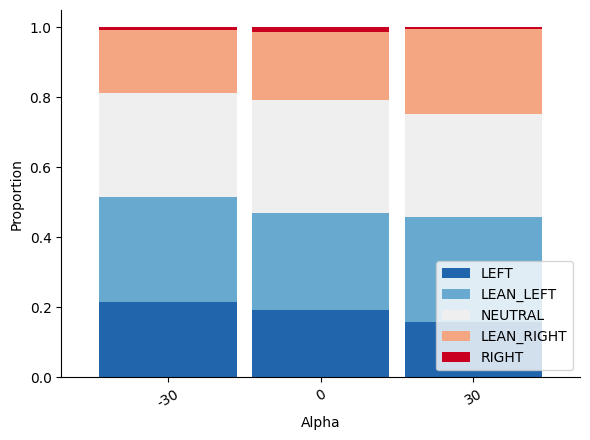

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the data
df = pd.read_csv(f"{results_dir}/{base_name}/{prefix}_intervention_rewrite_labeled.csv")

# Filter for k = 32 only
df_k32 = df[df["k"] == 32].copy()
df_k32["alpha"] = df_k32["alpha"].astype(int)

# Define label order and colors
label_order = ["LEFT", "LEAN_LEFT", "NEUTRAL", "LEAN_RIGHT", "RIGHT"]
custom_colors = {
    "LEFT": "#2166ac",       # dark blue
    "LEAN_LEFT": "#67a9cf",  # light blue
    "NEUTRAL": "#efefef",    # gray/white
    "LEAN_RIGHT": "#f4a582", # light red
    "RIGHT": "#ca0020"       # dark red
}

# Count distribution across alphas, then normalize to proportions
dist = (
    df_k32.groupby(["alpha", "parsed_label"])
    .size()
    .unstack(fill_value=0)[label_order]
)
dist_prop = dist.div(dist.sum(axis=1), axis=0)

# Plot stacked bar chart (proportions)
fig, ax = plt.subplots(figsize=(6, 4.5))
dist_prop.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    color=[custom_colors[c] for c in label_order],
    width=0.9
)

ax.set_xlabel("Alpha")
ax.set_ylabel("Proportion")

# Place legend inside plot (top right)
ax.legend(loc="lower right")

# Keep x-tick labels horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
os.makedirs(f"./figs/{base_name}/", exist_ok=True)
plt.savefig(f"./figs/{base_name}/rewrite_intervention_plot.pdf", bbox_inches='tight')
plt.show()


## Probing DeepSeek

In [ ]:
model_path = "/scratch/midway3/tzhang3/models/DeepSeek-R1-0528-Qwen3-8B"

In [ ]:
tokenizer, model = load_tokenizer_and_model(model_path, device=device)

In [ ]:
model.model.layers[0].self_attn

In [ ]:
features = extract_and_save_features(
    model,
    tokenizer,
    model_path,
    df_prompts_politicians,
    device=device,
)

In [ ]:
features.shape

In [ ]:
performance, ridge_models = train_ridge_models(
    model,
    model_path,
    data_dir="results",
    prefix="politician",
    alpha=1.0,
    n_splits=2,
    seed=SEED
)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ridge_models, performance = load_ridge_models(model_path, "politician")

# Sort each row from high to low
performance_temp = (performance * 100).astype(int)
performance_temp = -np.sort(-performance_temp, axis=1)  # or use: np.sort(performance * -1, axis=1) * -1

plt.figure(figsize=(10, 8), dpi=150)
ax = sns.heatmap(performance_temp, annot=True, cmap='viridis', cbar=True, vmin=0, vmax=100)
ax.invert_yaxis()

plt.title('Heatmap (Rows Sorted High to Low)')
plt.xlabel('Sorted Head Index')
plt.ylabel('Layer Index')
plt.show()


## Qwen3 VL

In [ ]:
from transformers import AutoModelForImageTextToText, AutoProcessor

model_path = "/home/tzhang3/jevans/models/Qwen3-VL-8B-Instruct"

# default: Load the model on the available device(s)
model = AutoModelForImageTextToText.from_pretrained(
    model_path, dtype="auto", device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = AutoModelForImageTextToText.from_pretrained(
#     "Qwen/Qwen3-VL-235B-A22B-Instruct",
#     dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

processor = AutoProcessor.from_pretrained(model_path)

In [36]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "./data/trump/getty/gettyimages-1676230181-612x612.jpg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['This is a candid, medium shot of former U.S. President Donald Trump, captured as he peeks out from behind a heavy blue curtain.\n\n**Key Elements:**\n\n*   **Subject:** Donald Trump is the central focus, positioned slightly off-center. He is looking toward the camera with a subtle, almost mischievous or curious expression. He is dressed formally in a dark suit, white shirt, and a bright blue tie.\n*   **Setting:** He is emerging from behind a thick, royal blue curtain, which dominates the left side of the frame. The curtain is draped and creates deep folds, suggesting a stage or formal event']


  0%|          | 0/552 [00:00<?, ?it/s]

Saved features to results/qwen3-vl-8b-instruct/politician_features.pkl


Layers:   0%|          | 0/36 [00:00<?, ?it/s]

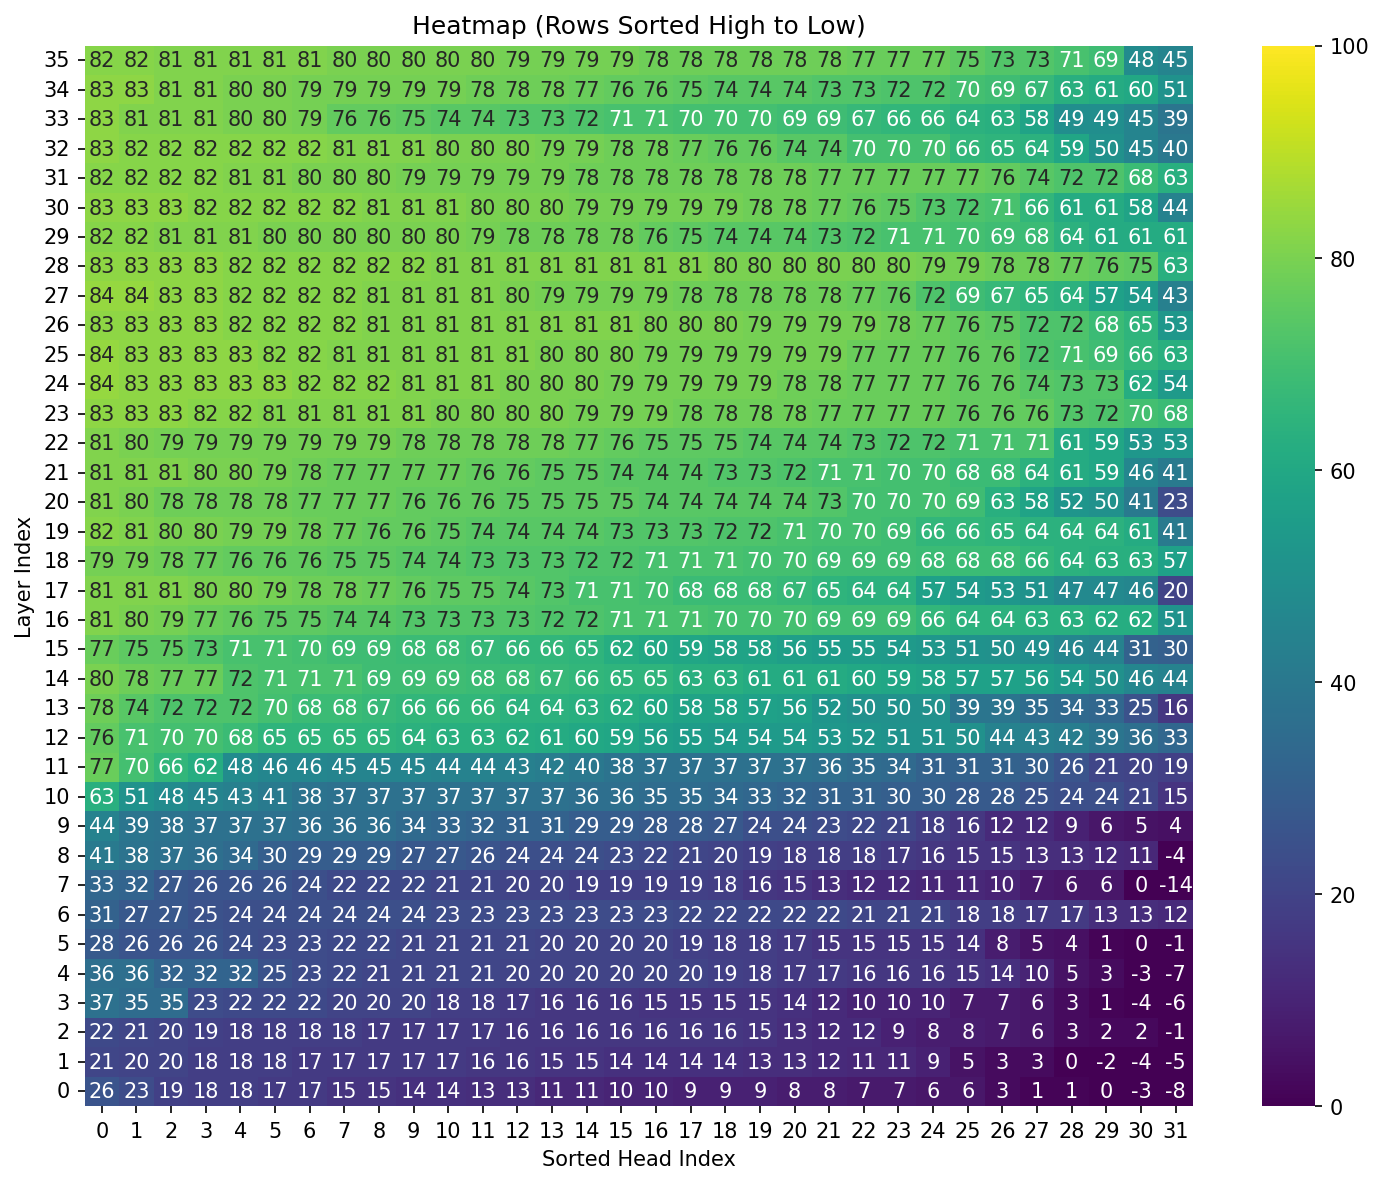

(<Axes: title={'center': 'Heatmap (Rows Sorted High to Low)'}, xlabel='Sorted Head Index', ylabel='Layer Index'>,
 array([[0.26116547, 0.07841856, 0.1479459 , ..., 0.19996125, 0.08387339,
         0.06554231],
        [0.05577317, 0.14131196, 0.03220738, ..., 0.11189963, 0.16844547,
         0.13504028],
        [0.02295562, 0.09408123, 0.16946387, ..., 0.07945926, 0.21215394,
         0.16293469],
        ...,
        [0.8049679 , 0.81266874, 0.7694393 , ..., 0.7556557 , 0.722377  ,
         0.76217365],
        [0.63413775, 0.7080503 , 0.6774776 , ..., 0.7474773 , 0.7466241 ,
         0.78904563],
        [0.80190855, 0.45702225, 0.7820357 , ..., 0.7896371 , 0.7553187 ,
         0.7762024 ]], shape=(36, 32), dtype=float32),
 {0: {0: Ridge(fit_intercept=False),
   1: Ridge(fit_intercept=False),
   2: Ridge(fit_intercept=False),
   3: Ridge(fit_intercept=False),
   4: Ridge(fit_intercept=False),
   5: Ridge(fit_intercept=False),
   6: Ridge(fit_intercept=False),
   7: Ridge(fit_interce

In [ ]:
def encode_prompt(processor, prompt: str):
    """Encode vision model inputs using a chat template."""
    messages = [{
        "role": "user",
        "content": [{"type": "text", "text": prompt}],
    }]
    return processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt"
    )

prompts = [encode_prompt(processor, p) for p in df_prompts_politicians["prompt"].values]

probe_heads(
    model_path,
    model=model,
    prompts=prompts,
    labels=df_prompts_politicians["label"].values,
    prefix="politician",
    alpha=1.0,
    n_splits=2,
    seed=SEED,
    data_dir="results",
    figsize=(10, 8),
    dpi=150,
    cmap='viridis',
    vmin=0,
    vmax=100,
    mode="vision",
    device=device
)

In [40]:
def encode_prompt(processor, image_path):
    """Encode vision model inputs using a chat template."""
    messages = [{
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {"type": "text", "text": "Generate a news article that accompany this image"}
        ],
    }]
    return processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt"
    )

images = os.listdir("./data/trump/pos/")
prompts = [encode_prompt(processor, f"./data/trump/pos/{img}") for img in images]

generate_and_score_tokens(
    model_path=model_path,
    prompts=prompts,
    model=model,
    tokenizer=processor.tokenizer,
    max_new_tokens=512,
    k=16,
    ridge_prefix="politician",
    visualize=True,
    mode="vision",
    device=device
)

  0%|          | 0/3 [00:00<?, ?it/s]

[{'features': array([[[[ 5.24902344e-02,  1.12304688e-02,  3.96728516e-03, ...,
             1.19628906e-02,  5.52368164e-03,  8.85009766e-03],
           [ 5.24902344e-02,  1.12304688e-02,  3.96728516e-03, ...,
             1.19628906e-02,  5.52368164e-03,  8.85009766e-03],
           [ 5.24902344e-02,  1.12304688e-02,  3.96728516e-03, ...,
             1.19628906e-02,  5.52368164e-03,  8.85009766e-03],
           ...,
           [ 3.34167480e-03,  4.32128906e-02,  1.95312500e-02, ...,
             1.78222656e-02, -4.71191406e-02, -1.70898438e-02],
           [ 3.34167480e-03,  4.32128906e-02,  1.95312500e-02, ...,
             1.78222656e-02, -4.71191406e-02, -1.70898438e-02],
           [ 3.34167480e-03,  4.32128906e-02,  1.95312500e-02, ...,
             1.78222656e-02, -4.71191406e-02, -1.70898438e-02]],
  
          [[-3.14941406e-02, -2.67333984e-02,  3.63769531e-02, ...,
             9.21630859e-03,  6.44531250e-02, -5.44433594e-02],
           [-3.14941406e-02, -2.67333984e-02

In [41]:
images = os.listdir("./data/trump/neg/")
prompts = [encode_prompt(processor, f"./data/trump/neg/{img}") for img in images]

generate_and_score_tokens(
    model_path=model_path,
    prompts=prompts,
    model=model,
    tokenizer=processor.tokenizer,
    max_new_tokens=512,
    k=16,
    ridge_prefix="politician",
    visualize=True,
    mode="vision",
    device=device
)

  0%|          | 0/4 [00:00<?, ?it/s]

[{'features': array([[[[ 5.24902344e-02,  1.12304688e-02,  3.96728516e-03, ...,
             1.19628906e-02,  5.52368164e-03,  8.85009766e-03],
           [ 5.24902344e-02,  1.12304688e-02,  3.96728516e-03, ...,
             1.19628906e-02,  5.52368164e-03,  8.85009766e-03],
           [ 5.24902344e-02,  1.12304688e-02,  3.96728516e-03, ...,
             1.19628906e-02,  5.52368164e-03,  8.85009766e-03],
           ...,
           [ 3.34167480e-03,  4.32128906e-02,  1.95312500e-02, ...,
             1.78222656e-02, -4.71191406e-02, -1.70898438e-02],
           [ 3.34167480e-03,  4.32128906e-02,  1.95312500e-02, ...,
             1.78222656e-02, -4.71191406e-02, -1.70898438e-02],
           [ 3.34167480e-03,  4.32128906e-02,  1.95312500e-02, ...,
             1.78222656e-02, -4.71191406e-02, -1.70898438e-02]],
  
          [[-3.14941406e-02, -2.67333984e-02,  3.63769531e-02, ...,
             9.21630859e-03,  6.44531250e-02, -5.44433594e-02],
           [-3.14941406e-02, -2.67333984e-02